# Preperation

## Imports

In [ ]:
!pip install visualkeras
!pip install pydot
!pip install lime
!pip install imagehash
!pip install Augmentor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f2a724ac4b05cf8e556b77d9c56a9ad334f96c0fb97811f1be806f040cb64264
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 107.4 MB/s eta 0:00:00


In [ ]:
# Utilities
from google.colab import drive
import os
import numpy as np
import kagglehub
from pathlib import Path
import scipy.misc
import pydot
from IPython.display import SVG
import shutil
import random
import filecmp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import pandas as pd
from shutil import copy2
from sklearn.model_selection import train_test_split

# Images
import PIL
import imagehash
from skimage.metrics import structural_similarity as ssim

# Keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Rescaling, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import model_to_dot
from keras.initializers import glorot_uniform
from keras.metrics import Precision, Recall
import keras.backend as K

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal, GlorotUniform

# Visualisation
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import visualkeras
%matplotlib inline

# XAI
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
from lime import submodular_pick

K.set_image_data_format('channels_last')

## Environment

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Deep_learning_unit/AssignmentFinal')
folder = os.path.join('/content/drive/My Drive/Deep_learning_unit/AssignmentFinal')
!ls

Mounted at /content/drive
APPROVED_L6_COMP6066_2024-25_sub_brief.pdf  model_history.json	unique_dir_hamming_train
AssignmentFinal.ipynb			    PastExamples	unique_dir_hamming_train_augment
AssignmentTest.ipynb			    sedan.jpg		unique_dir_hamming_val
assignment_utils.py			    SUV.jpg
hatchback.jpg				    unique_dir_hamming


## Data Preparation

In [ ]:
# Download latest version
data_path = kagglehub.dataset_download("sujaykapadnis/vehicle-type-image-dataset")
data_dir = Path(data_path) / "Vehicle Type Image Dataset (Version 2) VTID2"
print("Path to dataset files:", data_dir)
print("Directory contents:", list(data_dir.glob("*")))

100%|██████████| 131M/131M [00:09<00:00, 15.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2
Directory contents: [PosixPath('/root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Hatchback'), PosixPath('/root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Seden'), PosixPath('/root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Pickup'), PosixPath('/root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/SUV'), PosixPath('/root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Other')]


In [ ]:
def print_dataset_info(data_path):
    image_count = len(list(data_path.glob('**/*.jpg')))

    class_dirs = [d for d in data_path.iterdir() if d.is_dir()]

    # Initialize a dictionary to store class counts and ratios
    class_counts = {}

    # Iterate through each class directory
    for class_dir in class_dirs:
        # Count the number of image files in the class directory
        num_images = len(list(class_dir.glob("*.jpg")))
        class_ratio = num_images / image_count if image_count > 0 else 0
        class_counts[class_dir.name] = (num_images, class_ratio)

    print(f"\nTotal number of images in dataset: {image_count}")
    for class_name, (count, ratio) in class_counts.items():
        print(f"Class: {class_name}, {count} images ({ratio:.2%})")

In [ ]:
print_dataset_info(data_dir)


Total number of images in dataset: 4793
Class: Hatchback, 602 images (12.56%)
Class: Seden, 1222 images (25.50%)
Class: Pickup, 1689 images (35.24%)
Class: SUV, 680 images (14.19%)
Class: Other, 600 images (12.52%)


In [ ]:
image_sizes = []

for image_path in data_dir.glob('**/*.jpg'):
    with PIL.Image.open(image_path) as img:
        image_sizes.append(img.size)

unique_sizes = set(image_sizes)
print("Unique image sizes in the dataset:", unique_sizes)

widths, heights = zip(*image_sizes)
print("Min width:", min(widths), "Max width:", max(widths))
print("Min height:", min(heights), "Max height:", max(heights))


Unique image sizes in the dataset: {(313, 200), (475, 787), (518, 340), (284, 173), (496, 321), (317, 206), (457, 329), (488, 353), (335, 223), (267, 205), (133, 125), (225, 208), (443, 467), (166, 158), (291, 189), (401, 735), (985, 606), (815, 423), (413, 300), (305, 209), (210, 200), (241, 453), (290, 229), (274, 221), (406, 669), (507, 343), (287, 160), (90, 140), (458, 307), (408, 715), (517, 393), (1786, 1270), (181, 178), (421, 276), (299, 170), (272, 153), (1044, 669), (1392, 821), (313, 190), (324, 199), (838, 420), (495, 346), (397, 714), (125, 255), (191, 200), (364, 271), (445, 345), (859, 479), (409, 279), (569, 380), (782, 524), (141, 119), (286, 208), (864, 450), (502, 326), (360, 242), (419, 328), (161, 298), (358, 583), (192, 142), (184, 174), (498, 333), (256, 162), (181, 168), (154, 151), (227, 400), (342, 387), (583, 413), (371, 530), (346, 357), (277, 486), (939, 727), (931, 723), (295, 247), (531, 380), (143, 118), (387, 744), (466, 659), (154, 164), (535, 350), (

In [ ]:
def plot_images_from_subdirectories(directory):
    """
    This function takes a directory and plots 3 random images from each subdirectory (class).

    Parameters:
    directory (str): The root directory containing subdirectories of images.
    """
    # Verify the directory exists
    if not os.path.isdir(directory):
        print(f"Directory '{directory}' does not exist.")
        return

    # Iterate over subdirectories
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    if not subdirectories:
        print(f"No subdirectories found in '{directory}'.")
        return

    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        images = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

        if len(images) == 0:
            print(f"No images found in subdirectory: {subdir}")
            continue

        # Select 3 random images (or fewer if less than 3 images are available)
        selected_images = random.sample(images, min(len(images), 3))

        # Plot the images
        print(f"Displaying images from class: {subdir}")
        fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
        if len(selected_images) == 1:
            axes = [axes]  # Ensure axes is iterable if there's only one image

        for img, ax in zip(selected_images, axes):
            img_path = os.path.join(subdir_path, img)
            try:
                with PIL.Image.open(img_path) as image:
                    ax.imshow(image)
                    ax.axis('off')
                    ax.set_title(img)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

        plt.show()

plot_images_from_subdirectories(data_dir)

Output hidden; open in https://colab.research.google.com to view.

## Loading Train and Validation

In [ ]:
def generate_data(batch_size, img_size, dir_path):

    # Load the dataset
    train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        label_mode='categorical',
        seed=1,
        subset='both',
        validation_split=0.2,
        image_size=img_size,
        batch_size=batch_size,
    )

    class_names = train_dataset.class_names
    normalization_layer = Rescaling(1./255)

    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Count images in each class for train dataset
    train_class_counts = {class_name: 0 for class_name in class_names}
    for _, labels in train_dataset:
        counts = labels.numpy().sum(axis=0)
        for i, class_name in enumerate(class_names):
            train_class_counts[class_name] += counts[i]

    # Count images in each class for validation dataset
    val_class_counts = {class_name: 0 for class_name in class_names}
    for _, labels in val_dataset:
        counts = labels.numpy().sum(axis=0)
        for i, class_name in enumerate(class_names):
            val_class_counts[class_name] += counts[i]

    # Print dataset statistics
    print("Number of batches in training dataset:", len(train_dataset))
    for images, labels in train_dataset.take(1):
        print("Train Images batch shape:", images.shape)
        print("Labels batch shape:", labels.shape)
        print("Pixel range (min, max):", images.numpy().min(), images.numpy().max())

    print("\nNumber of batches in validation dataset:", len(val_dataset))
    for images, labels in val_dataset.take(1):
        print("Validation Images batch shape:", images.shape)
        print("Labels batch shape:", labels.shape)
        print("Pixel range (min, max):", images.numpy().min(), images.numpy().max())

    # Print class distribution
    print("\nTrain Dataset Class Distribution:")
    for class_name, count in train_class_counts.items():
        print(f"  {class_name}: {count} images")

    print("\nValidation Dataset Class Distribution:")
    for class_name, count in val_class_counts.items():
        print(f"  {class_name}: {count} images")

    return train_dataset, val_dataset, class_names


In [ ]:
def plot_training_history(history, val=False):
    """
    Plots training and optionally validation accuracy and loss vs. epochs in a single figure.

    Args:
        history (History | dict): A History object returned by the `fit` method of a Keras model,
                                  or a dictionary of model names and their History objects.
        val (bool): If True, includes validation accuracy and loss in the plot. Default is False.
    """
    # If history is a single History object
    if isinstance(history, dict):
        plt.figure(figsize=(16, 12))  # Larger figure for multiple models

        # Iterate over each model in the dictionary
        for model_name, hist in history.items():
            # Extract accuracy and loss
            acc = hist.history.get('accuracy', [])
            loss = hist.history.get('loss', [])

            if val:
                val_acc = hist.history.get('val_accuracy', [])
                val_loss = hist.history.get('val_loss', [])

            epochs = range(1, len(acc) + 1)  # Number of epochs

            # Plot accuracy
            plt.subplot(2, 2, 1)  # Upper-left corner for accuracy
            if acc:
                plt.plot(epochs, acc, label=f'{model_name} Training Accuracy')
            if val and val_acc:
                plt.plot(epochs, val_acc, linestyle='dashed', label=f'{model_name} Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Plot loss
            plt.subplot(2, 2, 2)  # Upper-right corner for loss
            if loss:
                plt.plot(epochs, loss, label=f'{model_name} Training Loss')
            if val and val_loss:
                plt.plot(epochs, val_loss, linestyle='dashed', label=f'{model_name} Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    else:
        # Single history object
        acc = history.history.get('accuracy', [])
        loss = history.history.get('loss', [])

        if val:
            val_acc = history.history.get('val_accuracy', [])
            val_loss = history.history.get('val_loss', [])

        epochs = range(1, len(acc) + 1)  # Number of epochs

        # Create a figure with 2 subplots
        plt.figure(figsize=(12, 8))

        # Accuracy subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        if acc:
            plt.plot(epochs, acc, label='Training Accuracy')
        if val and val_acc:
            plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title('Training Accuracy' + (' and Validation Accuracy' if val else ''))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        if loss:
            plt.plot(epochs, loss, label='Training Loss')
        if val and val_loss:
            plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training Loss' + (' and Validation Loss' if val else ''))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_confusion_matrix(matrix, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_model(model, val_dataset, class_names):
    # Obtain true labels and predictions
    true_labels = []
    val_predictions = []

    for images, labels in val_dataset:
        preds = model.predict(images, verbose=0)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
        val_predictions.extend(np.argmax(preds, axis=1))  # Convert probabilities to class indices

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, val_predictions)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, class_names)

    return conf_matrix

# Experiments

In [ ]:
model_history_dictionary = {}

train_dataset, val_dataset, class_names = generate_data(batch_size=16, img_size=(64, 64), dir_path=data_dir)

Found 4793 files belonging to 5 classes.
Using 3835 files for training.
Using 958 files for validation.
Number of batches in training dataset: 240
Train Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Number of batches in validation dataset: 60
Validation Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Train Dataset Class Distribution:
  Hatchback: 486.0 images
  Other: 479.0 images
  Pickup: 1354.0 images
  SUV: 545.0 images
  Seden: 971.0 images

Validation Dataset Class Distribution:
  Hatchback: 116.0 images
  Other: 121.0 images
  Pickup: 335.0 images
  SUV: 135.0 images
  Seden: 251.0 images


## Baseline Model

In [ ]:
def get_baseline_model(name="baseline_model"):

    model = Sequential(name=name)

    # 1st Conv Layer
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=[64, 64, 3]))
    # Pool Layer
    model.add(MaxPooling2D((2, 2)))
    # 2nd Conv Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'))
    # Pool Layer
    model.add(MaxPooling2D((2, 2)))
    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                          loss='categorical_crossentropy',
                          metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,885 (1.55 MB)

 Trainable params: 406,885 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


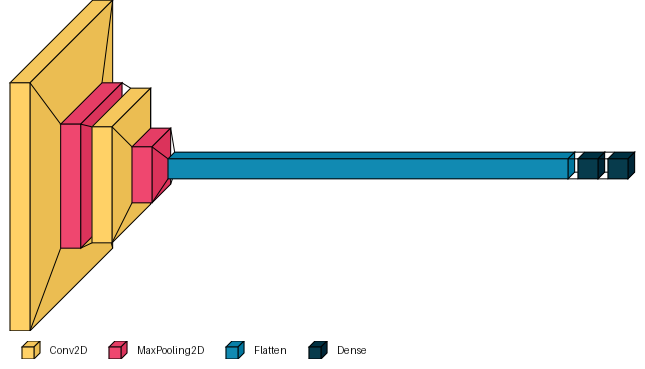

In [ ]:
baseline_model = get_baseline_model()
baseline_model.summary()
visualkeras.layered_view(baseline_model, legend=True)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.5938 - loss: 1.0922 - precision: 0.7257 - recall: 0.3915 - val_accuracy: 0.8873 - val_loss: 0.3272 - val_precision: 0.9239 - val_recall: 0.8612
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8938 - loss: 0.2990 - precision: 0.9198 - recall: 0.8654 - val_accuracy: 0.9061 - val_loss: 0.2726 - val_precision: 0.9088 - val_recall: 0.8946
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9720 - loss: 0.1046 - precision: 0.9771 - recall: 0.9639 - val_accuracy: 0.9729 - val_loss: 0.0765 - val_precision: 0.9759 - val_recall: 0.9718
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9866 - loss: 0.0473 - precision: 0.9886 - recall: 0.9849 - val_accuracy: 0.9906 - val_loss: 0.0451 - val_precision: 0.9906 - val_recall: 0.9906
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9947 - loss: 0.0195 - precision: 0.9948 - recall: 0.9947 - val_accuracy: 0.9948 - va

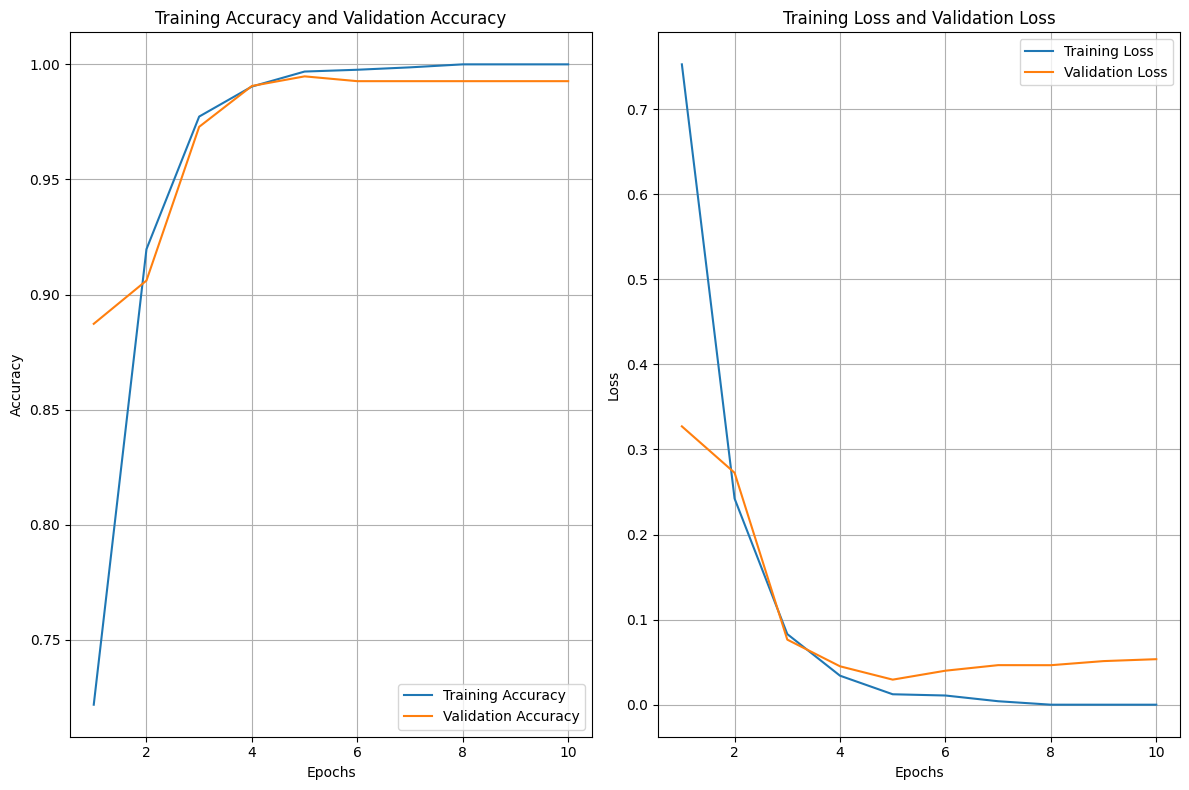

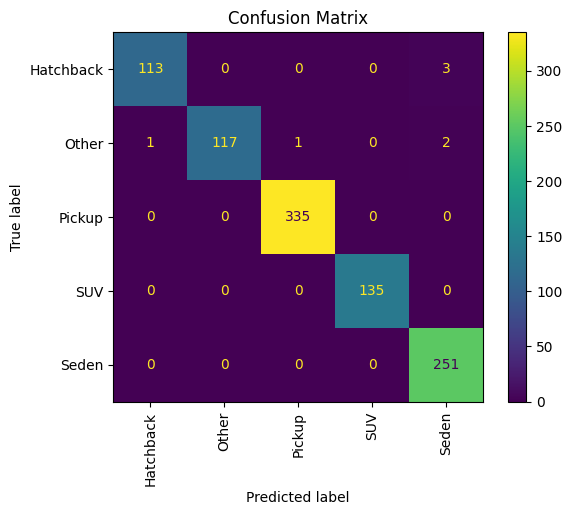

In [ ]:
baseline_history = baseline_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

model_history_dictionary['baseline_model'] = baseline_history
plot_training_history(baseline_history, val=True)
conf_matrix = evaluate_model(baseline_model, val_dataset, class_names)

## Experiment 1 - Dropping duplicate images

In [ ]:
def copy_unique_images(dataset_directory, output_directory, hamming_threshold=10):
    """
    Copy unique images from a dataset to a new directory while maintaining the structure.

    Parameters:
        dataset_directory (str): Path to the root directory of the dataset.
        output_directory (str): Path to the directory where unique images will be copied.
        hamming_threshold (int): Maximum Hamming distance to consider hashes as similar.
    """
    image_hashes = {}

    for root, _, files in os.walk(dataset_directory):
        for file in files:
            file_path = os.path.join(root, file)

            # Skip non-image files
            if not file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                continue

            image_hash = imagehash.phash(PIL.Image.open(file_path))

            if image_hash:
                found_duplicate = False
                for stored_hash, stored_path in image_hashes.items():
                    # Compare hashes using Hamming distance
                    hamming_distance = image_hash - stored_hash
                    if hamming_distance <= hamming_threshold:
                        print(f"Duplicate found (Hamming={hamming_distance}), skipping: {file_path}")
                        found_duplicate = True
                        break

                if not found_duplicate:
                    # Store hash and copy file
                    image_hashes[image_hash] = file_path

                    # Determine the relative path to maintain directory structure
                    relative_path = os.path.relpath(file_path, dataset_directory)
                    destination_path = os.path.join(output_directory, relative_path)

                    # Create target directory if it doesn't exist
                    os.makedirs(os.path.dirname(destination_path), exist_ok=True)

                    # Copy the unique file
                    shutil.copy2(file_path, destination_path)

In [ ]:
dataset_directory = data_dir
output_directory = "unique_dir_hamming"
hamming_threshold = 1
print(f"Processing dataset at: {dataset_directory}")
copy_unique_images(dataset_directory, output_directory, hamming_threshold)
print("Unique images copied to the new directory.")

Processing dataset at: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2
Duplicate found (Hamming=0), skipping: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Hatchback/PHOTO_284.jpg
Duplicate found (Hamming=0), skipping: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Hatchback/PHOTO_419.jpg
Duplicate found (Hamming=0), skipping: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Hatchback/PHOTO_322.jpg
Duplicate found (Hamming=0), skipping: /root/.cache/kagglehub/datasets/sujaykapadnis/vehicle-type-image-dataset/versions/1/Vehicle Type Image Dataset (Version 2) VTID2/Hatchback/PHOTO_176.jpg
Duplicate found (Hamming=0), skipping: /root/.cache/kagglehub/datasets/sujaykapa

In [ ]:
print_dataset_info(Path("unique_dir_hamming"))


Total number of images in dataset: 2574
Class: Hatchback, 296 images (11.50%)
Class: Seden, 605 images (23.50%)
Class: Pickup, 955 images (37.10%)
Class: SUV, 187 images (7.26%)
Class: Other, 531 images (20.63%)


In [ ]:
train_dataset_pruned, val_dataset_pruned, class_names = generate_data(batch_size=16, img_size=(64, 64), dir_path=Path("unique_dir_hamming"))

Found 2574 files belonging to 5 classes.
Using 2060 files for training.
Using 514 files for validation.
Number of batches in training dataset: 129
Train Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Number of batches in validation dataset: 33
Validation Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Train Dataset Class Distribution:
  Hatchback: 238.0 images
  Other: 421.0 images
  Pickup: 754.0 images
  SUV: 151.0 images
  Seden: 496.0 images

Validation Dataset Class Distribution:
  Hatchback: 58.0 images
  Other: 110.0 images
  Pickup: 201.0 images
  SUV: 36.0 images
  Seden: 109.0 images


In [ ]:
baseline_model_pruned = get_baseline_model("baseline_model_pruned")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.5856 - loss: 1.1056 - precision: 0.7055 - recall: 0.3887 - val_accuracy: 0.8074 - val_loss: 0.5478 - val_precision: 0.8736 - val_recall: 0.7665
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8620 - loss: 0.4056 - precision: 0.9062 - recall: 0.8160 - val_accuracy: 0.8735 - val_loss: 0.3606 - val_precision: 0.9149 - val_recall: 0.8366
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9293 - loss: 0.2504 - precision: 0.9426 - recall: 0.9069 - val_accuracy: 0.9008 - val_loss: 0.3584 - val_precision: 0.9165 - val_recall: 0.8755
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9456 - loss: 0.1599 - precision: 0.9594 - recall: 0.9355 - val_accuracy: 0.8969 - val_loss: 0.2854 - val_precision: 0.9125 - val_recall: 0.8930
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9773 - loss: 0.0806 - precision: 0.9799 - recall: 0.9750 - val_accuracy: 0.9241

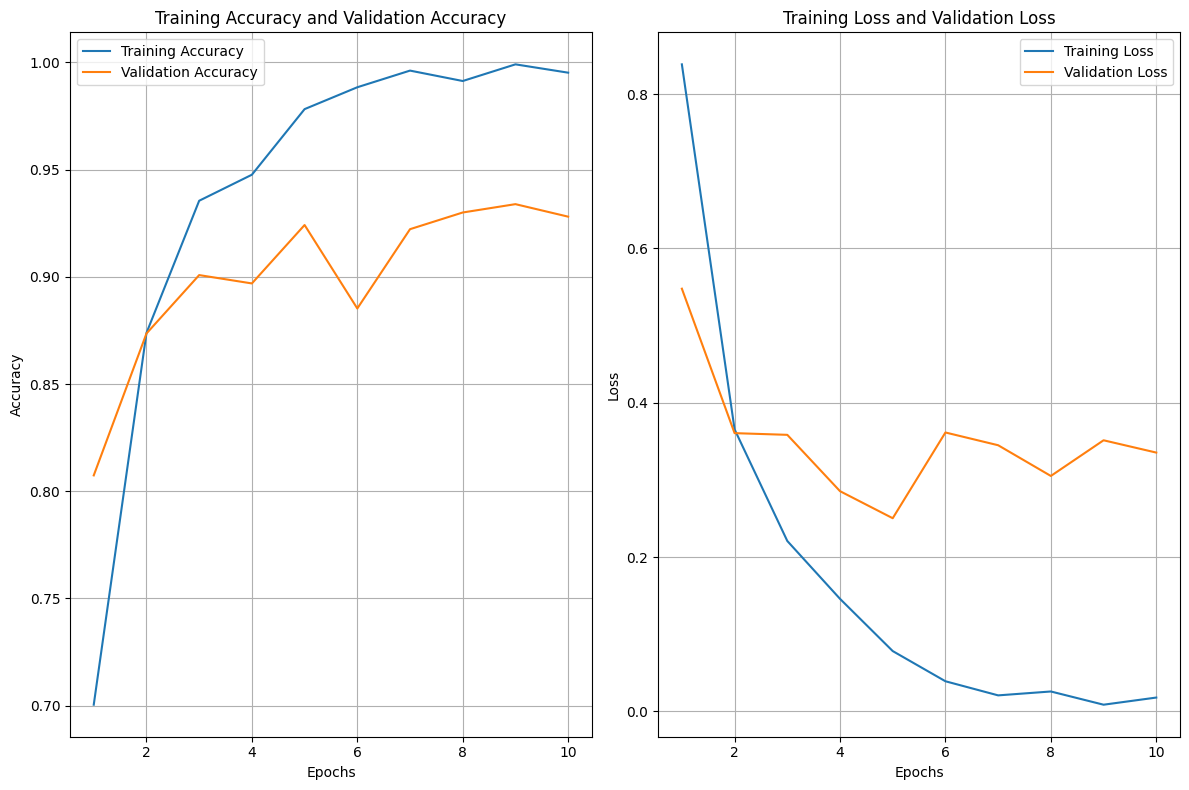

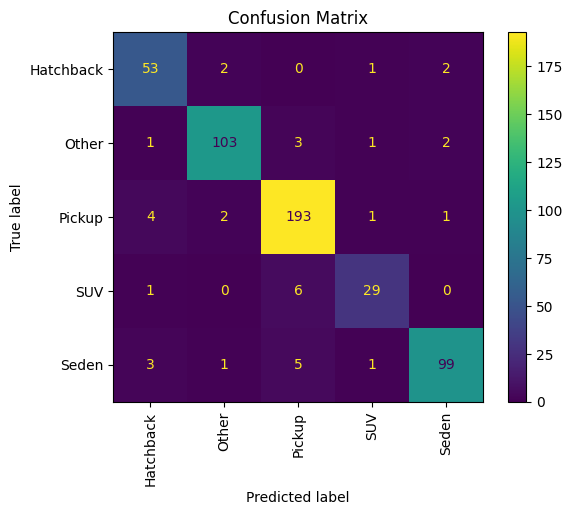

In [ ]:
baseline_pruned_history = baseline_model_pruned.fit(
    train_dataset_pruned,
    epochs=10,
    validation_data=val_dataset_pruned
)

model_history_dictionary['baseline_model_pruned'] = baseline_pruned_history
plot_training_history(baseline_pruned_history, val=True)
conf_matrix = evaluate_model(baseline_model_pruned, val_dataset_pruned, class_names)

## Experiment 2 - More layers

In [ ]:
def get_ex_block_model(name="ex_block_model"):
    model = Sequential(name=name)

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ex_block_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 9, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,005 (539.08 KB)

 Trainable params: 138,005 (539.08 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


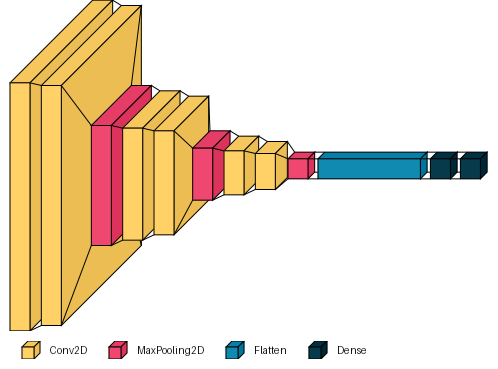

In [ ]:
ex_block_model = get_ex_block_model()
ex_block_model.summary()
visualkeras.layered_view(ex_block_model, legend=True)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.4588 - loss: 1.3352 - precision: 0.5859 - recall: 0.1530 - val_accuracy: 0.6070 - val_loss: 1.2130 - val_precision: 0.6204 - val_recall: 0.5914
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7307 - loss: 0.8162 - precision: 0.8183 - recall: 0.6241 - val_accuracy: 0.8191 - val_loss: 0.5698 - val_precision: 0.8799 - val_recall: 0.7412
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8194 - loss: 0.5316 - precision: 0.8782 - recall: 0.7725 - val_accuracy: 0.8093 - val_loss: 0.5510 - val_precision: 0.8547 - val_recall: 0.7782
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8705 - loss: 0.3921 - precision: 0.9041 - recall: 0.8436 - val_accuracy: 0.8696 - val_loss: 0.4142 - val_precision: 0.8905 - val_recall: 0.8385
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9058 - loss: 0.2767 - precision: 0.9287 - recall: 0.8884 - val_accuracy: 0.8949 - val_lo

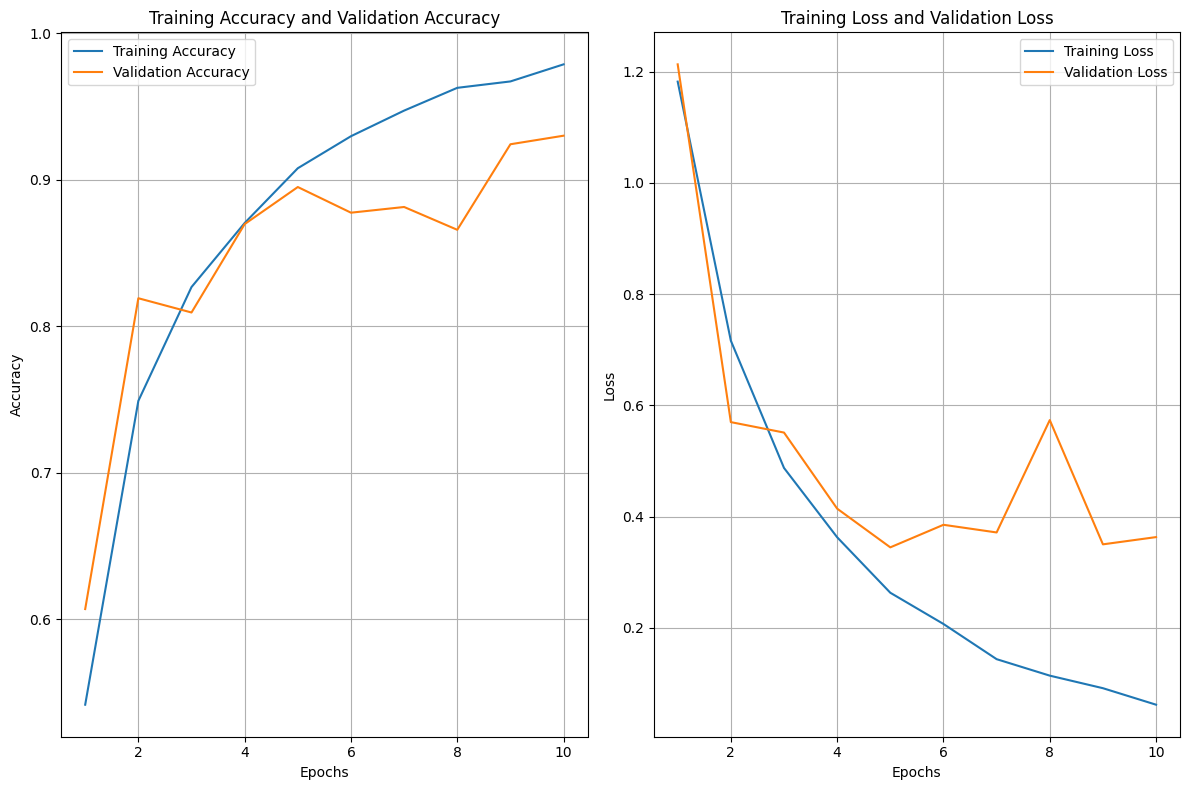

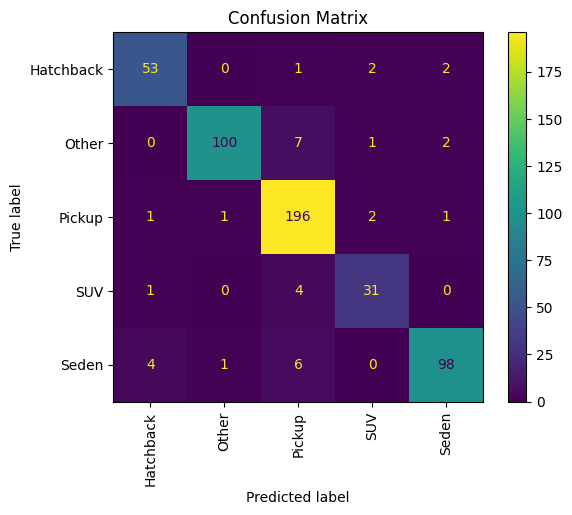

array([[ 53,   0,   1,   2,   2],
       [  0, 100,   7,   1,   2],
       [  1,   1, 196,   2,   1],
       [  1,   0,   4,  31,   0],
       [  4,   1,   6,   0,  98]])

In [ ]:
ex_block_model_history = ex_block_model.fit(
    train_dataset_pruned,
    epochs=10,
    validation_data=val_dataset_pruned
)

model_history_dictionary['ex_block_model'] = ex_block_model_history
plot_training_history(ex_block_model_history, val=True)
evaluate_model(ex_block_model, val_dataset_pruned, class_names)

## Experiment 3 - Padding

In [ ]:
def get_padding_model(name="padding_model"):
    model = Sequential(name=name)

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.3880 - loss: 1.4764 - precision: 0.3519 - recall: 0.0493 - val_accuracy: 0.7140 - val_loss: 0.8561 - val_precision: 0.8247 - val_recall: 0.5584
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7432 - loss: 0.7810 - precision: 0.8293 - recall: 0.6463 - val_accuracy: 0.8054 - val_loss: 0.5299 - val_precision: 0.8809 - val_recall: 0.7626
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8397 - loss: 0.4290 - precision: 0.8794 - recall: 0.8021 - val_accuracy: 0.8541 - val_loss: 0.4379 - val_precision: 0.8780 - val_recall: 0.8405
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8993 - loss: 0.2657 - precision: 0.9137 - recall: 0.8869 - val_accuracy: 0.8833 - val_loss: 0.3544 - val_precision: 0.9000 - val_recall: 0.8755
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9492 - loss: 0.1470 - precision: 0.9537 - recall: 0.9412 - val_accuracy: 0.9183 - val_loss: 0.2721 

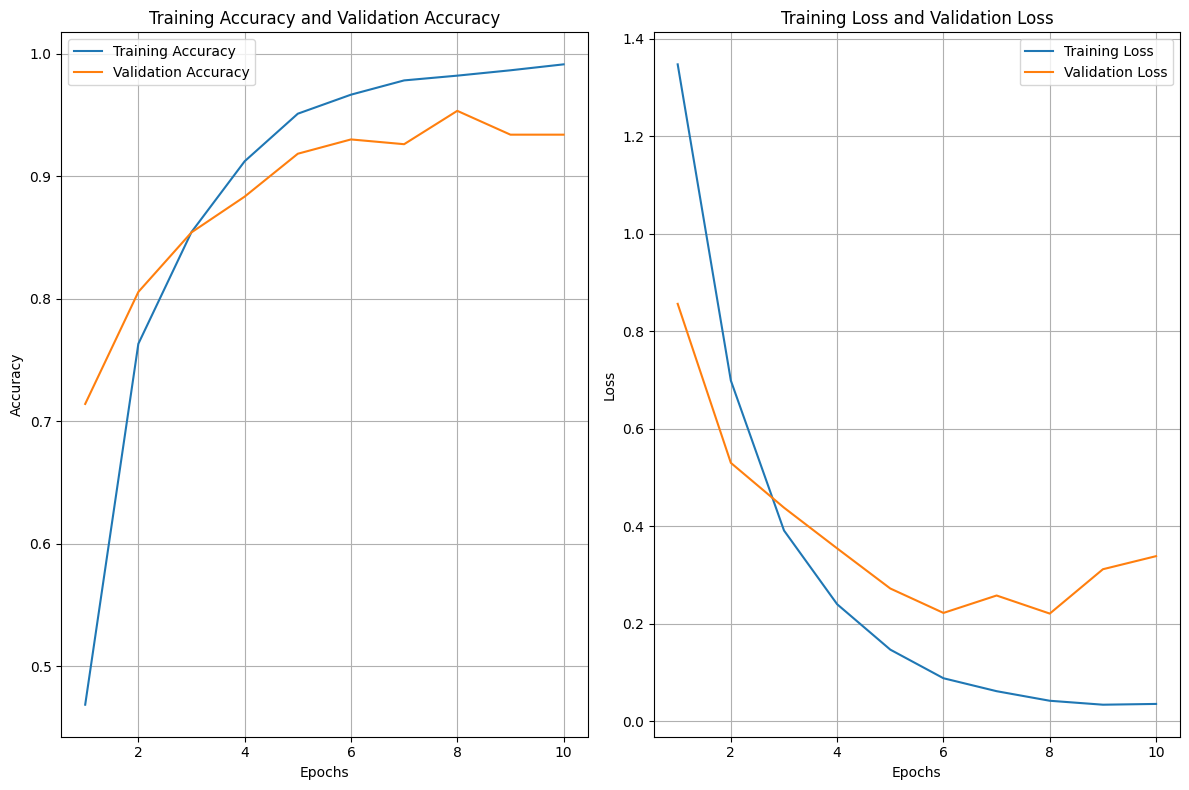

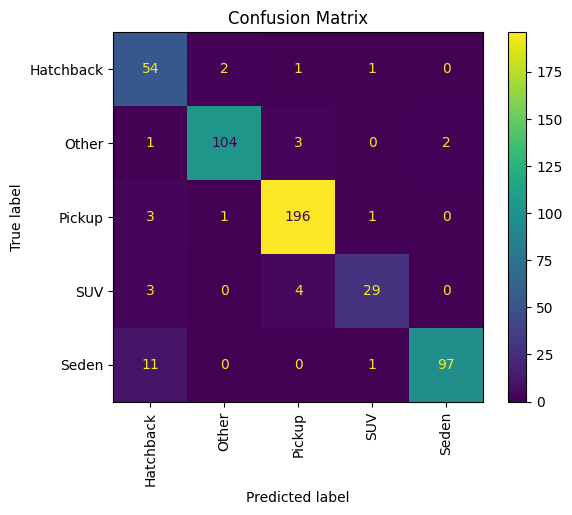

array([[ 54,   2,   1,   1,   0],
       [  1, 104,   3,   0,   2],
       [  3,   1, 196,   1,   0],
       [  3,   0,   4,  29,   0],
       [ 11,   0,   0,   1,  97]])

In [ ]:
padding_model = get_padding_model()
padding_model_history = padding_model.fit(
    train_dataset_pruned,
    epochs=10,
    validation_data=val_dataset_pruned
)

plot_training_history(padding_model_history, val=True)
evaluate_model(padding_model, val_dataset_pruned, class_names)

## Experiment 4 - Kernel Sizes

In [ ]:
def get_kernel_size_model(kernel_size):

    model_name = f"kernel_size_model_{kernel_size[0]}x{kernel_size[1]}"
    model = Sequential(name=model_name)

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=kernel_size, activation='relu', padding='same', input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=kernel_size, activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4386 - loss: 1.4348 - precision: 0.5535 - recall: 0.1401 - val_accuracy: 0.7724 - val_loss: 0.6925 - val_precision: 0.8417 - val_recall: 0.7140
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7883 - loss: 0.6264 - precision: 0.8547 - recall: 0.7261 - val_accuracy: 0.8541 - val_loss: 0.4199 - val_precision: 0.8750 - val_recall: 0.8307
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8738 - loss: 0.3640 - precision: 0.9067 - recall: 0.8465 - val_accuracy: 0.8560 - val_loss: 0.3576 - val_precision: 0.8968 - val_recall: 0.8288
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9359 - loss: 0.2120 - precision: 0.9443 - recall: 0.9236 - val_accuracy: 0.8949 - val_loss: 0.2929 - val_precision: 0.9050 - val_recall: 0.8891
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9559 - loss: 0.1319 - precision: 0.9609 - recall: 0.9508 - val_accuracy: 0.9125 - val_lo

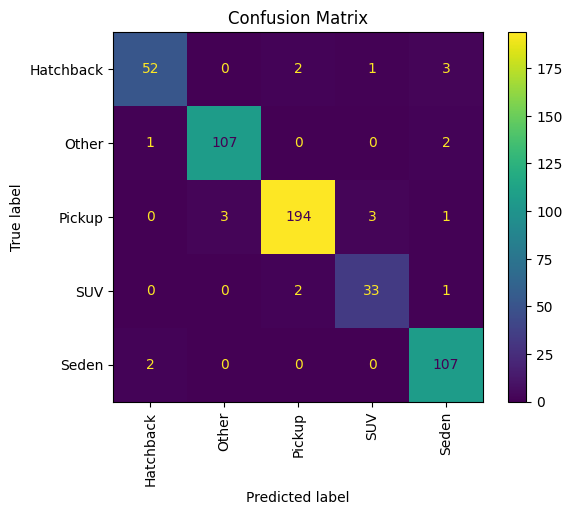

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.4161 - loss: 1.4566 - precision: 0.5259 - recall: 0.1027 - val_accuracy: 0.7160 - val_loss: 0.7896 - val_precision: 0.8488 - val_recall: 0.5681
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7352 - loss: 0.7821 - precision: 0.8093 - recall: 0.6215 - val_accuracy: 0.7977 - val_loss: 0.5695 - val_precision: 0.8443 - val_recall: 0.7704
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8172 - loss: 0.5093 - precision: 0.8839 - recall: 0.7732 - val_accuracy: 0.8521 - val_loss: 0.3943 - val_precision: 0.9079 - val_recall: 0.7860
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8874 - loss: 0.3143 - precision: 0.9140 - recall: 0.8654 - val_accuracy: 0.8833 - val_loss: 0.3192 - val_precision: 0.8958 - val_recall: 0.8696
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9260 - loss: 0.2000 - precision: 0.9350 - recall: 0.9160 - val_accuracy: 0.8444 - val_loss: 0.4901 

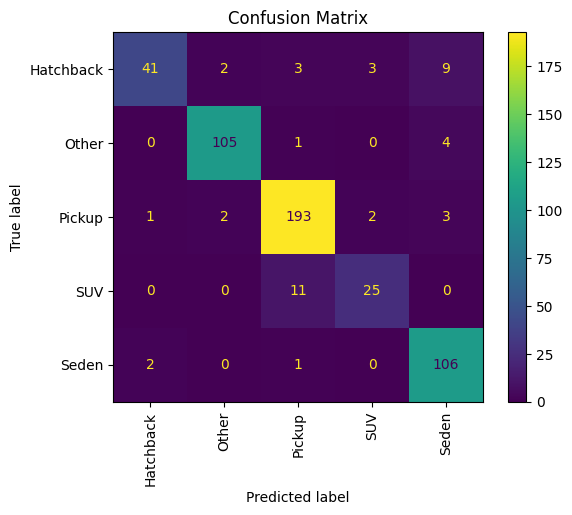

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.3719 - loss: 2.0362 - precision: 0.3172 - recall: 0.0352 - val_accuracy: 0.3911 - val_loss: 1.4645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4077 - loss: 1.4218 - precision: 0.4920 - recall: 0.0664 - val_accuracy: 0.6634 - val_loss: 0.9070 - val_precision: 0.7524 - val_recall: 0.6089
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7340 - loss: 0.8353 - precision: 0.7908 - recall: 0.6098 - val_accuracy: 0.7626 - val_loss: 0.6748 - val_precision: 0.8848 - val_recall: 0.6128
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8172 - loss: 0.5798 - precision: 0.8654 - recall: 0.7543 - val_accuracy: 0.8016 - val_loss: 0.6307 - val_precision: 0.9153 - val_recall: 0.6518
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8454 - loss: 0.4357 - precision: 0.8878 - recall: 0.8001 - val_accuracy: 0.8307 - val_loss:

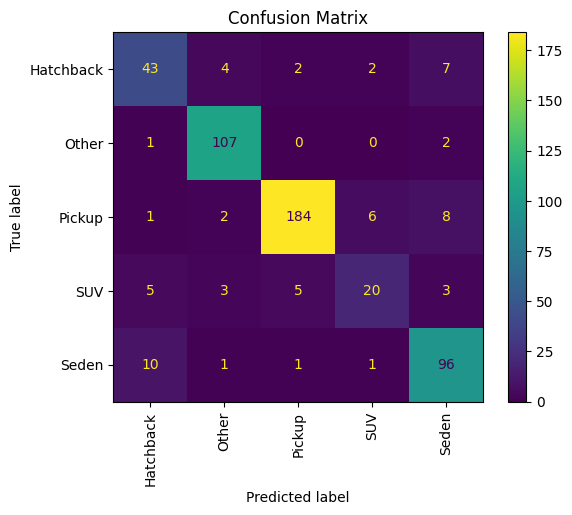

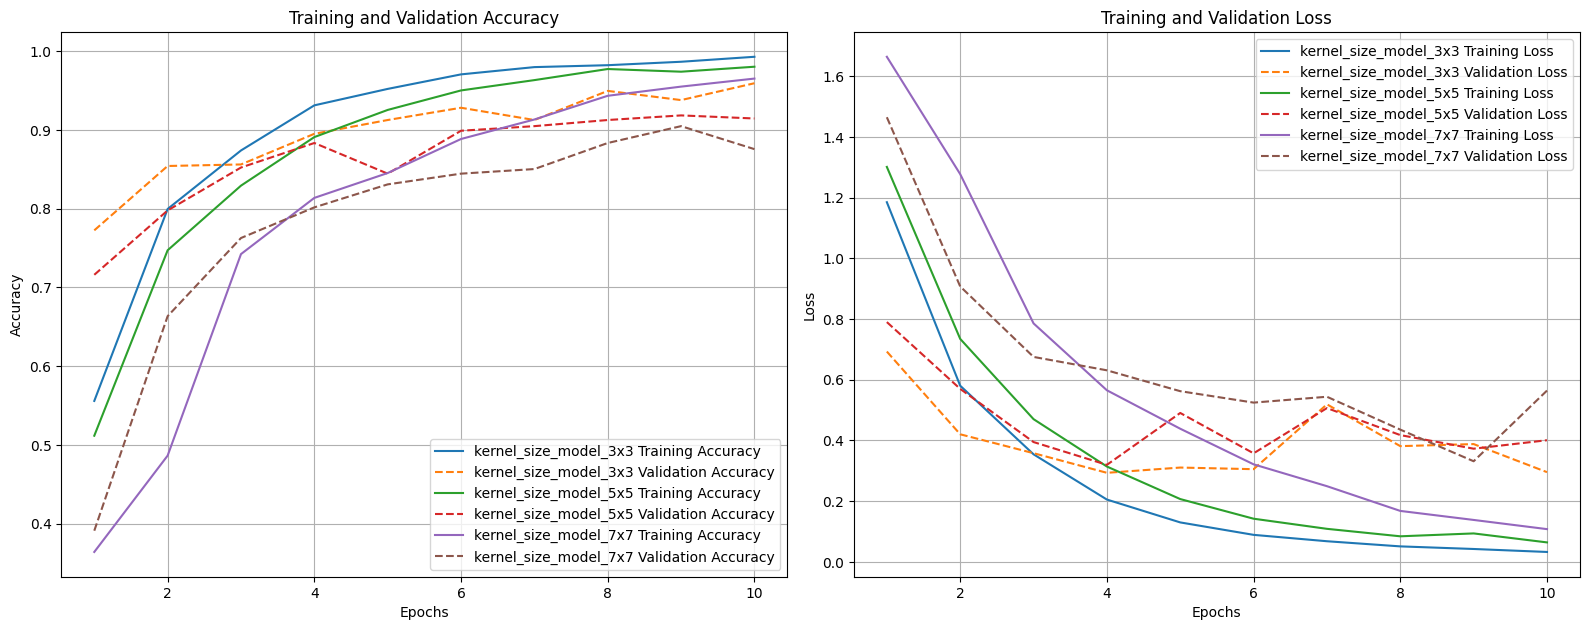

In [ ]:
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
kernel_size_models = []
kernel_size_histories = {}

for kernel_size in kernel_sizes:
    kernel_size_model = get_kernel_size_model(kernel_size)
    kernel_size_models.append(kernel_size_model)
    kernel_size_history = kernel_size_model.fit(
        train_dataset_pruned,
        epochs=10,
        validation_data=val_dataset_pruned
    )
    kernel_size_histories[kernel_size_model.name] = kernel_size_history
    evaluate_model(kernel_size_model, val_dataset_pruned, class_names)

plot_training_history(kernel_size_histories, val=True)

## Experiment 5 - Optimizer

In [ ]:
def get_optimizer_model(optimizer):
    optimizer_type = type(optimizer).__name__
    model_name = f"optimizer_model_{optimizer_type}"
    model = Sequential(name=model_name)

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.4290 - loss: 1.4065 - precision: 0.5146 - recall: 0.0910 - val_accuracy: 0.6829 - val_loss: 0.9406 - val_precision: 0.8277 - val_recall: 0.4767
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.6918 - loss: 0.8661 - precision: 0.7750 - recall: 0.6133 - val_accuracy: 0.7724 - val_loss: 0.6882 - val_precision: 0.8529 - val_recall: 0.6206
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7988 - loss: 0.5658 - precision: 0.8635 - recall: 0.7280 - val_accuracy: 0.8327 - val_loss: 0.5019 - val_precision: 0.9117 - val_recall: 0.7432
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.8580 - loss: 0.3908 - precision: 0.9027 - recall: 0.8207 - val_accuracy: 0.8658 - val_loss: 0.3691 - val_precision: 0.8905 - val_recall: 0.8385
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8950 - loss: 0.2790 - precision: 0.9144 - recall: 0.8798 - val_accuracy: 0.9027 - 

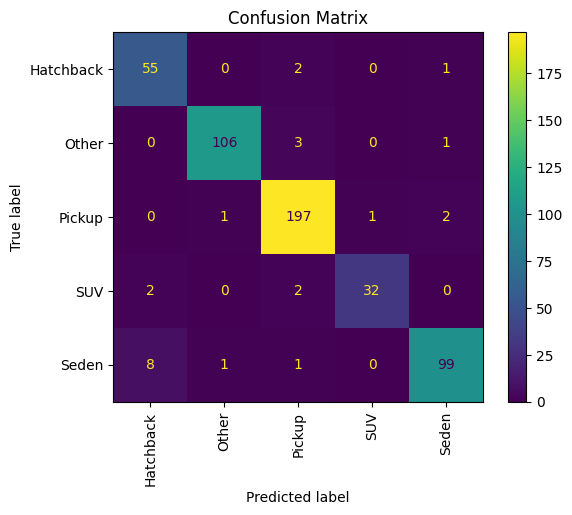

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.5439 - loss: 1.1840 - precision: 0.6564 - recall: 0.2844 - val_accuracy: 0.7899 - val_loss: 0.5719 - val_precision: 0.8791 - val_recall: 0.7354
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.8322 - loss: 0.4803 - precision: 0.8768 - recall: 0.7966 - val_accuracy: 0.8930 - val_loss: 0.3492 - val_precision: 0.9196 - val_recall: 0.8677
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9079 - loss: 0.2593 - precision: 0.9308 - recall: 0.8934 - val_accuracy: 0.8969 - val_loss: 0.3047 - val_precision: 0.9104 - val_recall: 0.8891
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.9359 - loss: 0.1661 - precision: 0.9437 - recall: 0.9312 - val_accuracy: 0.9144 - val_loss: 0.2464 - val_precision: 0.9267 - val_recall: 0.9105
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9648 - loss: 0.0934 - precision: 0.9672 - recall: 0.9596 - val_accuracy: 0.9416 - val_loss: 0.

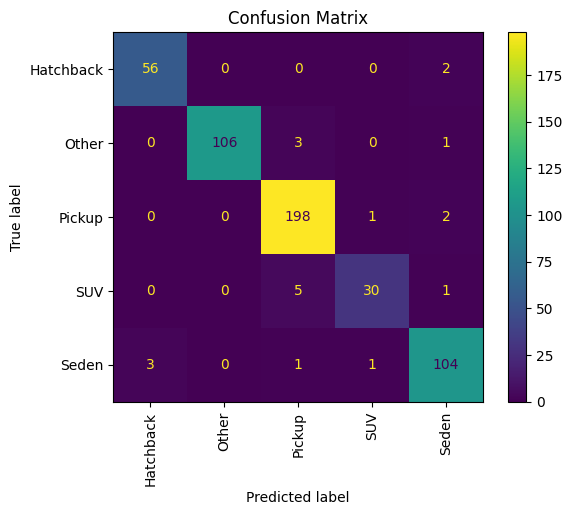

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.4124 - loss: 1.4601 - precision: 0.5079 - recall: 0.0929 - val_accuracy: 0.7276 - val_loss: 0.8428 - val_precision: 0.8392 - val_recall: 0.5992
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.7668 - loss: 0.6969 - precision: 0.8398 - recall: 0.7057 - val_accuracy: 0.8230 - val_loss: 0.4755 - val_precision: 0.8616 - val_recall: 0.8113
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8507 - loss: 0.4150 - precision: 0.8857 - recall: 0.8166 - val_accuracy: 0.8833 - val_loss: 0.3160 - val_precision: 0.9175 - val_recall: 0.8658
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9061 - loss: 0.2630 - precision: 0.9211 - recall: 0.8931 - val_accuracy: 0.9319 - val_loss: 0.1941 - val_precision: 0.9423 - val_recall: 0.9222
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9487 - loss: 0.1419 - precision: 0.9565 - recall: 0.9414 - val_accuracy: 0.8949 - val_loss: 0.26

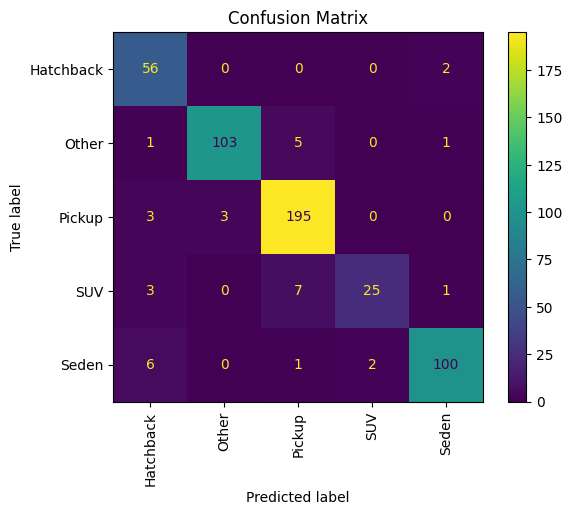

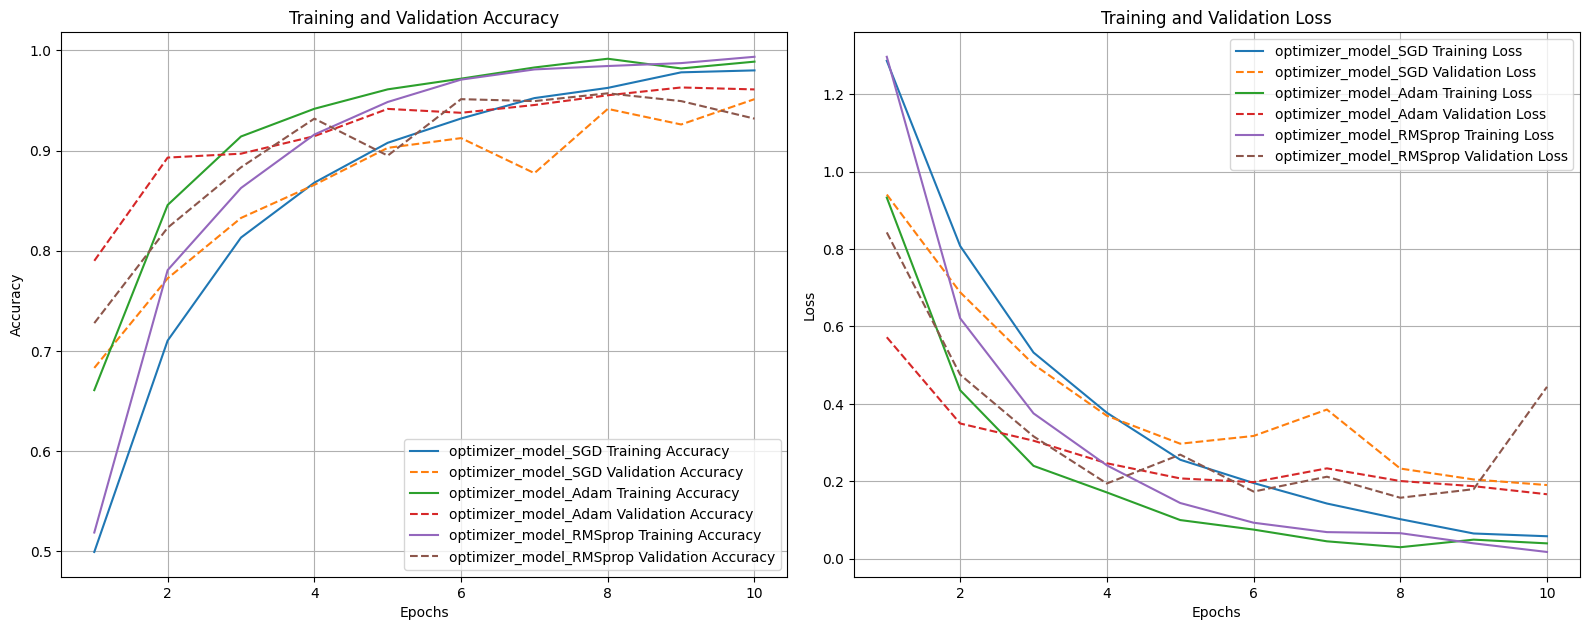

In [ ]:
optimizers = [
    tf.keras.optimizers.SGD(momentum=0.9),
    tf.keras.optimizers.Adam(learning_rate=0.001),
    tf.keras.optimizers.RMSprop(learning_rate=0.001)
]
optimizer_models = []
optimizer_histories = {}

for optimizer in optimizers:
    optimizer_model = get_optimizer_model(optimizer)
    optimizer_models.append(optimizer_model)
    optimizer_history = optimizer_model.fit(
        train_dataset_pruned,
        epochs=10,
        validation_data=val_dataset_pruned
    )
    optimizer_histories[optimizer_model.name] = optimizer_history
    evaluate_model(optimizer_model, val_dataset_pruned, class_names)

plot_training_history(optimizer_histories, val=True)

## Experiment 6 - Activation Function

In [ ]:
def get_af_model(activation_function):
    model_name = f"af_model_{activation_function}"
    model = Sequential(name=model_name)

    # Choose initializer based on activation function
    if activation_function in ['relu', 'leaky_relu', 'swish']:
        initializer = HeNormal()
    elif activation_function == 'tanh':
        initializer = GlorotUniform()
    else:
        initializer = HeNormal()  # Default to HeNormal if unspecified

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation_function, padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation=activation_function))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.5156 - loss: 1.2281 - precision: 0.6597 - recall: 0.2611 - val_accuracy: 0.8327 - val_loss: 0.5202 - val_precision: 0.9182 - val_recall: 0.7646
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8649 - loss: 0.4117 - precision: 0.9043 - recall: 0.8264 - val_accuracy: 0.8852 - val_loss: 0.3330 - val_precision: 0.9459 - val_recall: 0.8502
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9287 - loss: 0.2022 - precision: 0.9466 - recall: 0.9169 - val_accuracy: 0.9222 - val_loss: 0.2591 - val_precision: 0.9350 - val_recall: 0.8949
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9518 - loss: 0.1370 - precision: 0.9562 - recall: 0.9441 - val_accuracy: 0.8911 - val_loss: 0.4050 - val_precision: 0.8996 - val_recall: 0.8891
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9604 - loss: 0.1036 - precision: 0.9651 - recall: 0.9584 - val_accuracy: 0.9241 - val_loss: 0.251

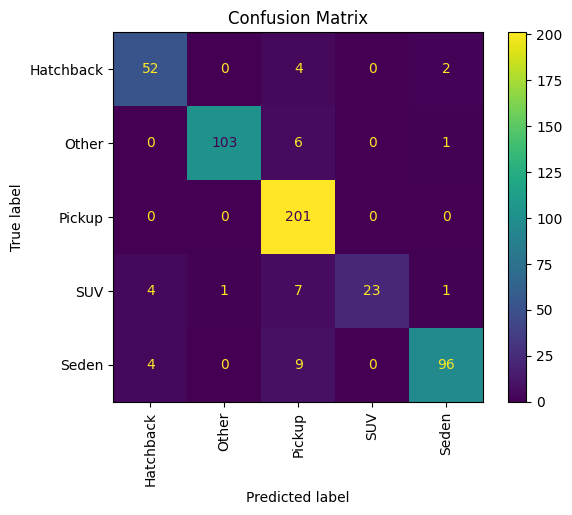

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.5450 - loss: 1.3678 - precision: 0.6710 - recall: 0.3877 - val_accuracy: 0.8463 - val_loss: 0.4367 - val_precision: 0.9091 - val_recall: 0.8171
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.8509 - loss: 0.4396 - precision: 0.8994 - recall: 0.8206 - val_accuracy: 0.8949 - val_loss: 0.3083 - val_precision: 0.9256 - val_recall: 0.8716
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9360 - loss: 0.2048 - precision: 0.9472 - recall: 0.9272 - val_accuracy: 0.9144 - val_loss: 0.2570 - val_precision: 0.9337 - val_recall: 0.9047
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9614 - loss: 0.1034 - precision: 0.9647 - recall: 0.9539 - val_accuracy: 0.9300 - val_loss: 0.2656 - val_precision: 0.9350 - val_recall: 0.9241
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9849 - loss: 0.0471 - precision: 0.9864 - recall: 0.9839 - val_accuracy: 0.9358 - val_loss: 0.323

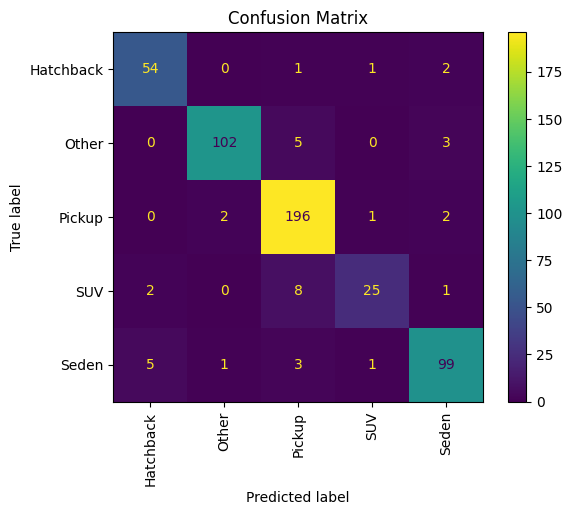

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.6733 - loss: 0.9518 - precision: 0.7339 - recall: 0.5559 - val_accuracy: 0.8619 - val_loss: 0.3809 - val_precision: 0.8968 - val_recall: 0.8288
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8974 - loss: 0.2939 - precision: 0.9215 - recall: 0.8831 - val_accuracy: 0.9163 - val_loss: 0.2486 - val_precision: 0.9396 - val_recall: 0.9086
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9627 - loss: 0.1181 - precision: 0.9668 - recall: 0.9548 - val_accuracy: 0.9319 - val_loss: 0.2078 - val_precision: 0.9441 - val_recall: 0.9202
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9878 - loss: 0.0447 - precision: 0.9933 - recall: 0.9847 - val_accuracy: 0.9455 - val_loss: 0.1667 - val_precision: 0.9492 - val_recall: 0.9455
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9937 - loss: 0.0245 - precision: 0.9937 - recall: 0.9937 - val_accuracy: 0.9553 - val_loss: 0.14

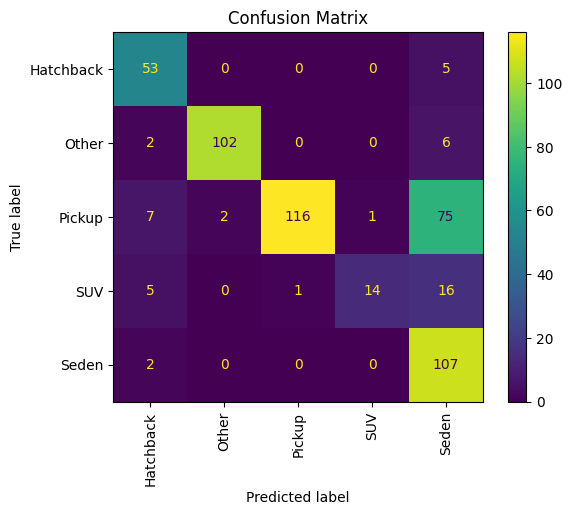

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.6430 - loss: 0.9652 - precision: 0.7704 - recall: 0.4819 - val_accuracy: 0.8307 - val_loss: 0.4326 - val_precision: 0.8802 - val_recall: 0.7860
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8980 - loss: 0.2878 - precision: 0.9231 - recall: 0.8776 - val_accuracy: 0.8949 - val_loss: 0.2911 - val_precision: 0.9226 - val_recall: 0.8813
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9611 - loss: 0.1311 - precision: 0.9691 - recall: 0.9546 - val_accuracy: 0.9241 - val_loss: 0.2285 - val_precision: 0.9253 - val_recall: 0.9163
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9880 - loss: 0.0434 - precision: 0.9888 - recall: 0.9842 - val_accuracy: 0.9377 - val_loss: 0.2623 - val_precision: 0.9411 - val_recall: 0.9319
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9893 - loss: 0.0359 - precision: 0.9896 - recall: 0.9877 - val_accuracy: 0.9377 - val_loss: 0.223

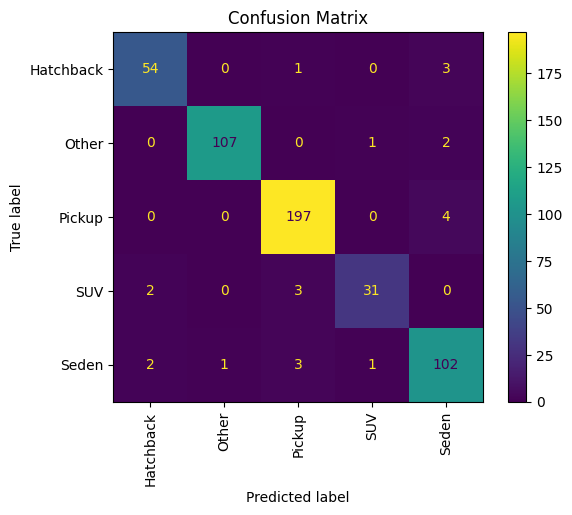

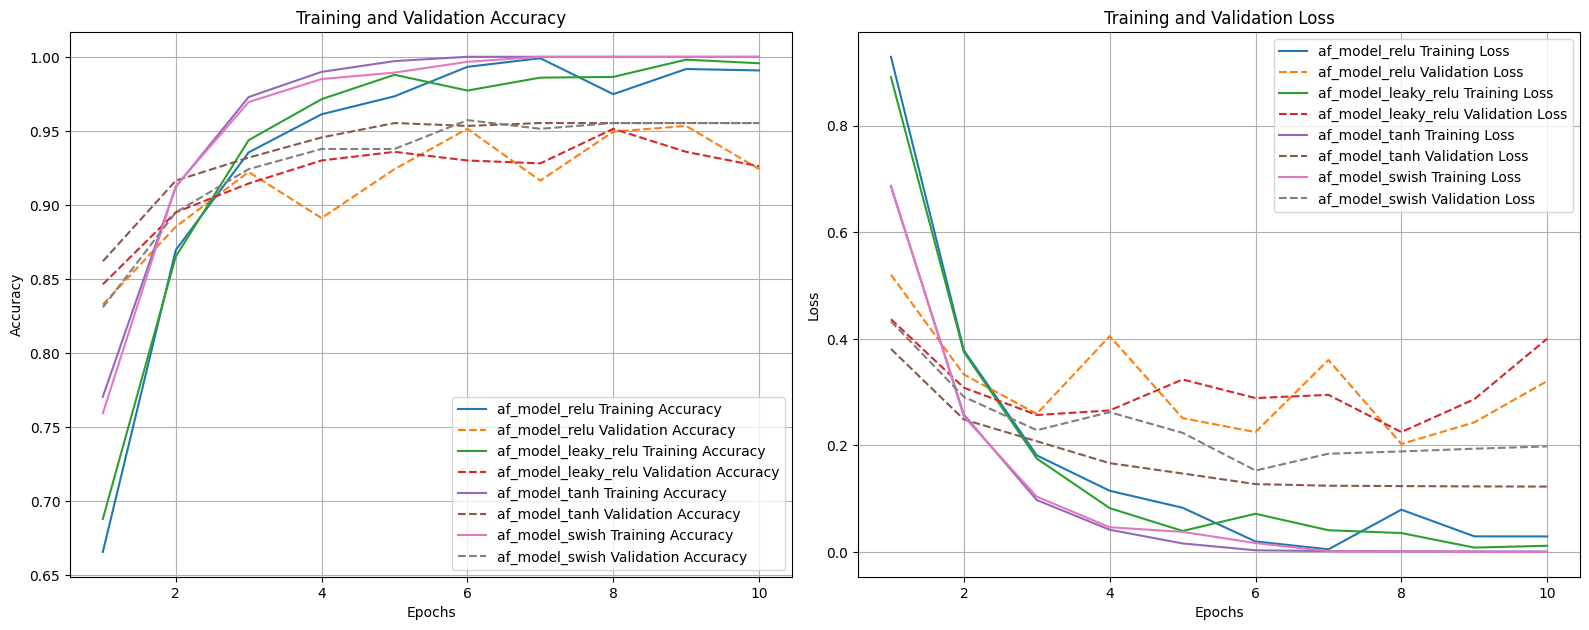

In [ ]:
activation_functions = ['relu', 'leaky_relu', 'tanh', 'swish']
af_models = []
af_histories = {}

def rescale_dataset_to_neg1_1(dataset):
    return dataset.map(lambda x, y: ((x * 2) - 1, y), num_parallel_calls=tf.data.AUTOTUNE)

for activation_function in activation_functions:
    # Rescale data only for Tanh
    if activation_function == 'tanh':
        af_train_data = rescale_dataset_to_neg1_1(train_dataset_pruned)
        af_val_data = rescale_dataset_to_neg1_1(val_dataset_pruned)
    else:
        af_train_data = train_dataset_pruned
        af_val_data = val_dataset_pruned

    af_model = get_af_model(activation_function)
    af_models.append(af_model)
    af_history = af_model.fit(
        af_train_data,
        epochs=10,
        validation_data=af_val_data
    )
    af_histories[af_model.name] = af_history
    evaluate_model(af_model, val_dataset_pruned, class_names)

plot_training_history(af_histories, val=True)

## Experiment 7 - Data Aumentation



In [ ]:
def split_dataset(source_dir, train_dir, val_dir, val_size=0.2):
    """
    Splits a dataset of images organized in subdirectories by class into training and testing sets.

    Parameters:
    - source_dir (str): Path to the source directory containing class subdirectories.
    - train_dir (str): Path to the training output directory.
    - val_dir (str): Path to the validation output directory.
    - val_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
    """
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exist.")
        return

    # Create the train and val directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Iterate through each class subdirectory
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Create class subdirectories in train and test folders
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Get list of all files in the class directory
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Split files into train and test
        train_files, val_files = train_test_split(files, test_size=val_size, random_state=42)

        # Move files to respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_class_dir, file))

    print("Dataset split completed!")

In [ ]:
source_path = "unique_dir_hamming"
train_path = "unique_dir_hamming_train"
val_path = "unique_dir_hamming_val"
train_augment_path = "unique_dir_hamming_train_augment"

# split_dataset(source_path, train_path, val_path)

In [ ]:
print_dataset_info(Path(train_path))
print_dataset_info(Path(val_path))


Total number of images in dataset: 2057
Class: Other, 424 images (20.61%)
Class: SUV, 149 images (7.24%)
Class: Pickup, 764 images (37.14%)
Class: Hatchback, 236 images (11.47%)
Class: Seden, 484 images (23.53%)

Total number of images in dataset: 517
Class: Other, 107 images (20.70%)
Class: SUV, 38 images (7.35%)
Class: Pickup, 191 images (36.94%)
Class: Hatchback, 60 images (11.61%)
Class: Seden, 121 images (23.40%)


In [ ]:
def augment_images(source_path, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    for root, dirs, files in os.walk(source_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = PIL.Image.open(img_path)

                # Preserve directory structure
                relative_path = os.path.relpath(root, source_path)
                save_dir = os.path.join(destination_path, relative_path)
                os.makedirs(save_dir, exist_ok=True)

                base_filename = os.path.splitext(file)[0]

                # Save original image
                img.save(os.path.join(save_dir, f"{base_filename}_original.jpg"))

                # Left-right flip
                lr_flip = PIL.ImageOps.mirror(img)
                lr_flip.save(os.path.join(save_dir, f"{base_filename}_lr_flip.jpg"))

                # Up-down flip
                ud_flip = PIL.ImageOps.flip(img)
                ud_flip.save(os.path.join(save_dir, f"{base_filename}_ud_flip.jpg"))

                # Left-right + Up-down flip
                lr_ud_flip = PIL.ImageOps.flip(lr_flip)
                lr_ud_flip.save(os.path.join(save_dir, f"{base_filename}_lr_ud_flip.jpg"))

                # Rotate +15 degrees
                rot_plus_15 = img.rotate(15, expand=True)
                rot_plus_15.save(os.path.join(save_dir, f"{base_filename}_rot_plus15.jpg"))

                # Rotate -15 degrees
                rot_minus_15 = img.rotate(-15, expand=True)
                rot_minus_15.save(os.path.join(save_dir, f"{base_filename}_rot_minus15.jpg"))

                # Left-right flip + Rotate +15 degrees
                lr_rot_plus_15 = lr_flip.rotate(15, expand=True)
                lr_rot_plus_15.save(os.path.join(save_dir, f"{base_filename}_lr_rot_plus15.jpg"))

                # Left-right flip + Rotate -15 degrees
                lr_rot_minus_15 = lr_flip.rotate(-15, expand=True)
                lr_rot_minus_15.save(os.path.join(save_dir, f"{base_filename}_lr_rot_minus15.jpg"))

In [ ]:
augment_images(train_path, train_augment_path)

In [ ]:
print_dataset_info(Path(train_augment_path))


Total number of images in dataset: 16456
Class: Other, 3392 images (20.61%)
Class: SUV, 1192 images (7.24%)
Class: Pickup, 6112 images (37.14%)
Class: Hatchback, 1888 images (11.47%)
Class: Seden, 3872 images (23.53%)


In [ ]:
img_size = (64, 64)
batch_size = 16

val_aug_dataset = tf.keras.utils.image_dataset_from_directory(
        val_path,
        label_mode='categorical',
        seed=1,
        image_size=img_size,
        batch_size=batch_size,
    )

train_aug_dataset = tf.keras.utils.image_dataset_from_directory(
        train_augment_path,
        label_mode='categorical',
        seed=1,
        image_size=img_size,
        batch_size=batch_size,
    )

class_names = train_aug_dataset.class_names
normalization_layer = Rescaling(1./255)

train_aug_dataset = train_aug_dataset.map(lambda x, y: (normalization_layer(x), y))
val_aug_dataset = val_aug_dataset.map(lambda x, y: (normalization_layer(x), y))

# Count images in each class for train dataset
train_class_counts = {class_name: 0 for class_name in class_names}
for _, labels in train_aug_dataset:
    counts = labels.numpy().sum(axis=0)
    for i, class_name in enumerate(class_names):
        train_class_counts[class_name] += counts[i]

# Count images in each class for validation dataset
val_class_counts = {class_name: 0 for class_name in class_names}
for _, labels in val_aug_dataset:
    counts = labels.numpy().sum(axis=0)
    for i, class_name in enumerate(class_names):
        val_class_counts[class_name] += counts[i]

# Print dataset statistics
print("Number of batches in training dataset:", len(train_aug_dataset))
for images, labels in train_aug_dataset.take(1):
    print("Train Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Pixel range (min, max):", images.numpy().min(), images.numpy().max())

print("\nNumber of batches in validation dataset:", len(val_aug_dataset))
for images, labels in val_aug_dataset.take(1):
    print("Validation Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Pixel range (min, max):", images.numpy().min(), images.numpy().max())

# Print class distribution
print("\nTrain Dataset Class Distribution:")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count} images")

print("\nValidation Dataset Class Distribution:")
for class_name, count in val_class_counts.items():
    print(f"  {class_name}: {count} images")

Found 517 files belonging to 5 classes.
Found 16456 files belonging to 5 classes.
Number of batches in training dataset: 1029
Train Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Number of batches in validation dataset: 33
Validation Images batch shape: (16, 64, 64, 3)
Labels batch shape: (16, 5)
Pixel range (min, max): 0.0 1.0

Train Dataset Class Distribution:
  Hatchback: 1888.0 images
  Other: 3392.0 images
  Pickup: 6112.0 images
  SUV: 1192.0 images
  Seden: 3872.0 images

Validation Dataset Class Distribution:
  Hatchback: 60.0 images
  Other: 107.0 images
  Pickup: 191.0 images
  SUV: 38.0 images
  Seden: 121.0 images


In [ ]:
def get_aug_data_model(model_name="aug_data_model"):

    model = Sequential(name=model_name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

In [ ]:
aug_data_model = get_aug_data_model()
aug_data_model_history = aug_data_model.fit(
    train_aug_dataset,
    epochs=10,
    validation_data=val_aug_dataset
)

plot_training_history(aug_data_model_history, val=True)
evaluate_model(aug_data_model, val_aug_dataset, class_names)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 286s 274ms/step - accuracy: 0.6840 - loss: 0.8870 - precision: 0.7804 - recall: 0.5575 - val_accuracy: 0.8607 - val_loss: 0.4061 - val_precision: 0.8882 - val_recall: 0.8298
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 278s 270ms/step - accuracy: 0.8863 - loss: 0.3277 - precision: 0.9105 - recall: 0.8626 - val_accuracy: 0.8665 - val_loss: 0.4277 - val_precision: 0.8866 - val_recall: 0.8472
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 279s 271ms/step - accuracy: 0.9407 - loss: 0.1760 - precision: 0.9492 - recall: 0.9333 - val_accuracy: 0.9072 - val_loss: 0.3165 - val_precision: 0.9157 - val_recall: 0.9033
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 283s 274ms/step - accuracy: 0.9586 - loss: 0.1186 - precision: 0.9617 - recall: 0.9545 - val_accuracy: 0.9265 - val_loss: 0.2948 - val_precision: 0.9318 - val_recall: 0.9246
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 277s 269ms/step - accuracy: 0.9704 - loss: 0.0884 - precision: 0.9715 - recall: 0.9680 - val_a

AttributeError: 'History' object has no attribute 'get'

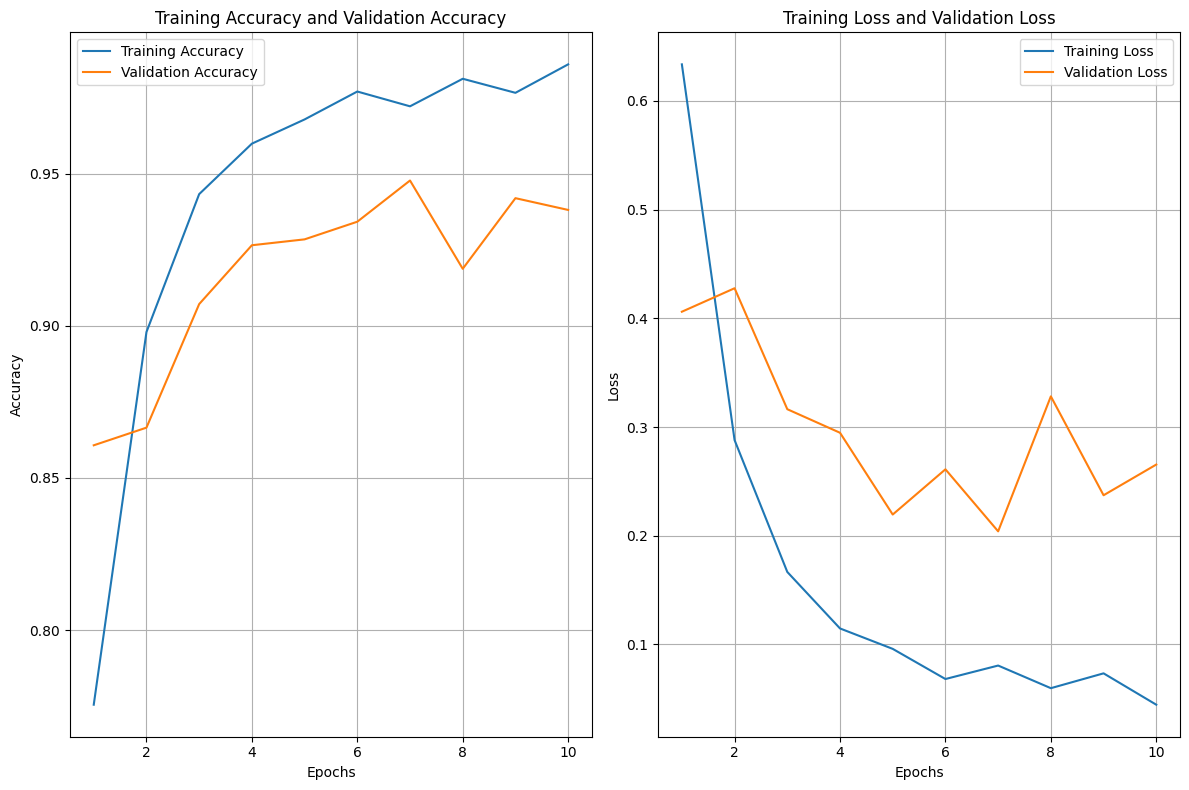

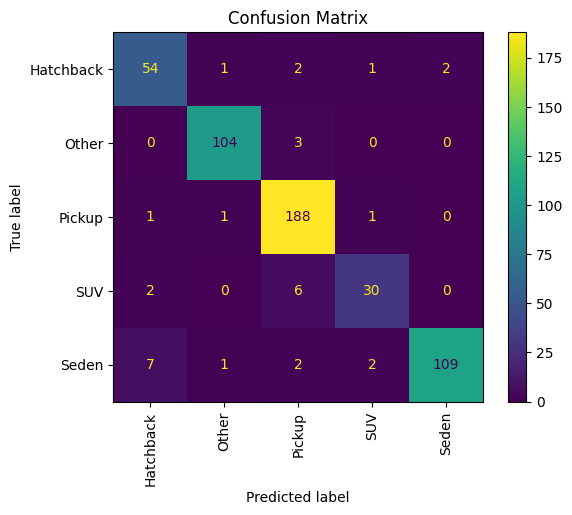

array([[ 54,   1,   2,   1,   2],
       [  0, 104,   3,   0,   0],
       [  1,   1, 188,   1,   0],
       [  2,   0,   6,  30,   0],
       [  7,   1,   2,   2, 109]])

In [ ]:
plot_training_history(aug_data_model_history, val=True)
evaluate_model(aug_data_model, val_aug_dataset, class_names)

## Experiment 8 - Batch Normalization

In [ ]:
def get_batch_norm_model(model_name="batch_norm_model"):
    model = Sequential(name=model_name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(BatchNormalization())

    # Pool Layer
    model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64), activation='swish',)
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 78s 65ms/step - accuracy: 0.6972 - loss: 0.8981 - precision: 0.7704 - recall: 0.6227 - val_accuracy: 0.8124 - val_loss: 0.5448 - val_precision: 0.8701 - val_recall: 0.7776
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.8560 - loss: 0.4249 - precision: 0.8867 - recall: 0.8261 - val_accuracy: 0.8917 - val_loss: 0.3398 - val_precision: 0.9141 - val_recall: 0.8646
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step - accuracy: 0.8999 - loss: 0.2926 - precision: 0.9220 - recall: 0.8819 - val_accuracy: 0.8839 - val_loss: 0.3381 - val_precision: 0.8944 - val_recall: 0.8685
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step - accuracy: 0.9251 - loss: 0.2144 - precision: 0.9348 - recall: 0.9137 - val_accuracy: 0.8298 - val_loss: 0.5185 - val_precision: 0.8410 - val_recall: 0.8182
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.9431 - loss: 0.1629 - precision: 0.9509 - recall: 0.9360 - val_accuracy: 0

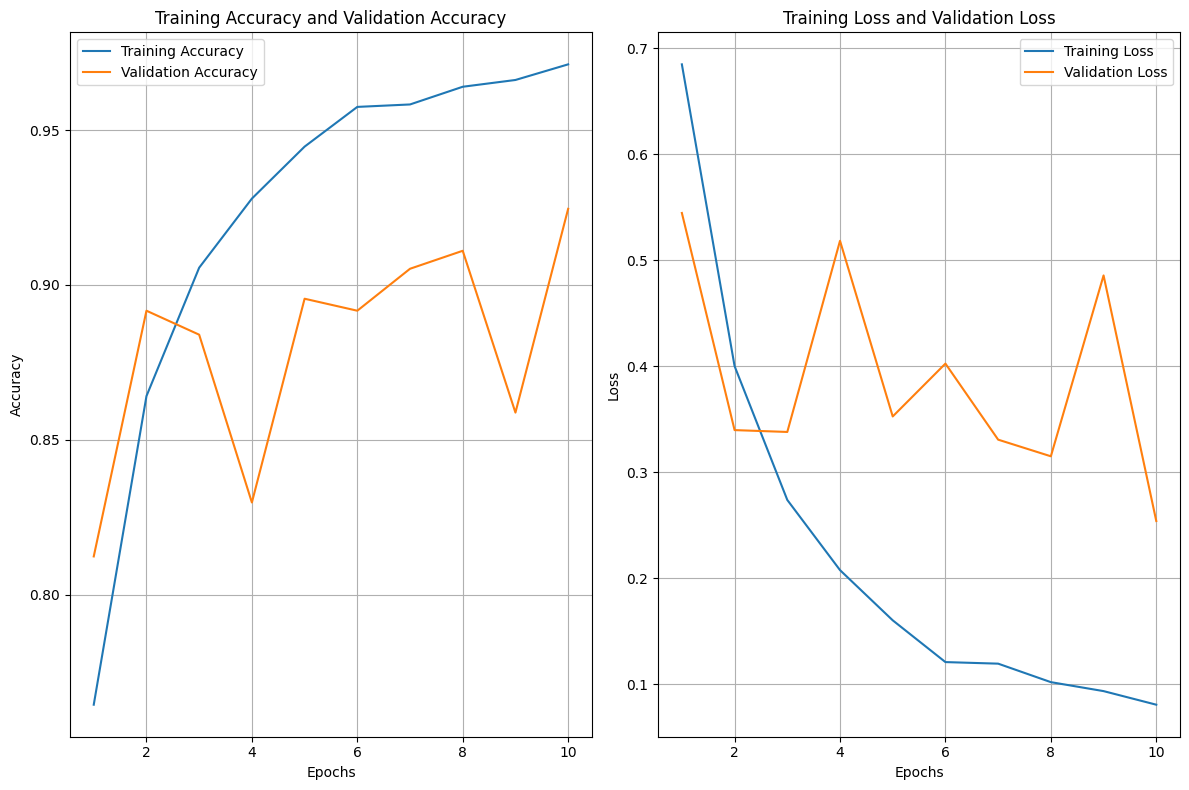

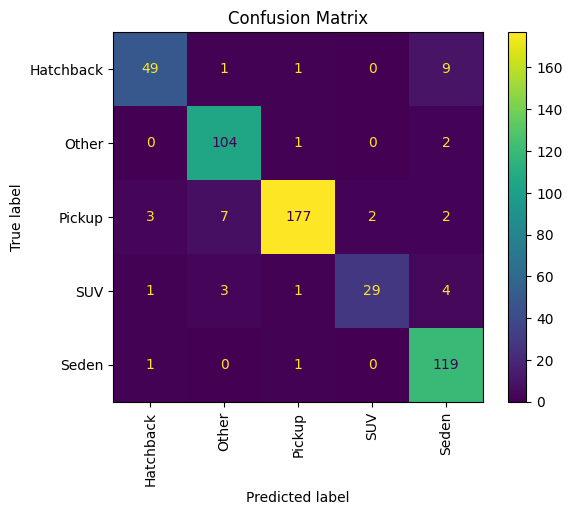

array([[ 49,   1,   1,   0,   9],
       [  0, 104,   1,   0,   2],
       [  3,   7, 177,   2,   2],
       [  1,   3,   1,  29,   4],
       [  1,   0,   1,   0, 119]])

In [ ]:
batch_norm_model = get_batch_norm_model()
batch_norm_model_history = batch_norm_model.fit(
    train_aug_dataset,
    epochs=10,
    validation_data=val_aug_dataset
)

plot_training_history(batch_norm_model_history, val=True)
evaluate_model(batch_norm_model, val_aug_dataset, class_names)

## Experiment 9 - Dropout Layers

In [ ]:
def get_dropout_model(dropout_rates):
    name = f"dropout_model_{'_'.join(map(str, dropout_rates))}"
    model = Sequential(name=name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rates[0]))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rates[1]))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rates[2]))

    # Flatten
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(dropout_rates[3]))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.5393 - loss: 1.3253 - precision: 0.6662 - recall: 0.3249 - val_accuracy: 0.7872 - val_loss: 0.6496 - val_precision: 0.8813 - val_recall: 0.6460
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7652 - loss: 0.6625 - precision: 0.8308 - recall: 0.6912 - val_accuracy: 0.8723 - val_loss: 0.3737 - val_precision: 0.9032 - val_recall: 0.8298
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8098 - loss: 0.5307 - precision: 0.8558 - recall: 0.7638 - val_accuracy: 0.8491 - val_loss: 0.3662 - val_precision: 0.8924 - val_recall: 0.8182
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8398 - loss: 0.4544 - precision: 0.8757 - recall: 0.8050 - val_accuracy: 0.8704 - val_loss: 0.3026 - val_precision: 0.9066 - val_recall: 0.8453
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8562 - loss: 0.4001 - precision: 0.8833 - recall: 0.8266 - val_accuracy: 0

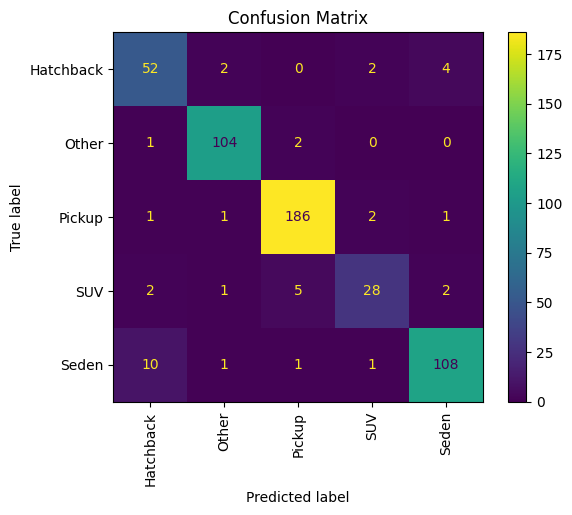

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4231 - loss: 1.6944 - precision: 0.5408 - recall: 0.1698 - val_accuracy: 0.6983 - val_loss: 0.8026 - val_precision: 0.8780 - val_recall: 0.5706
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6853 - loss: 0.8859 - precision: 0.7883 - recall: 0.5625 - val_accuracy: 0.7776 - val_loss: 0.6151 - val_precision: 0.8531 - val_recall: 0.6963
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7342 - loss: 0.7467 - precision: 0.8136 - recall: 0.6457 - val_accuracy: 0.7872 - val_loss: 0.5253 - val_precision: 0.8671 - val_recall: 0.7447
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7707 - loss: 0.6541 - precision: 0.8375 - recall: 0.7020 - val_accuracy: 0.8491 - val_loss: 0.4371 - val_precision: 0.9017 - val_recall: 0.7988
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7927 - loss: 0.6069 - precision: 0.8490 - recall: 0.7308 - val_accuracy: 0.8317 - val

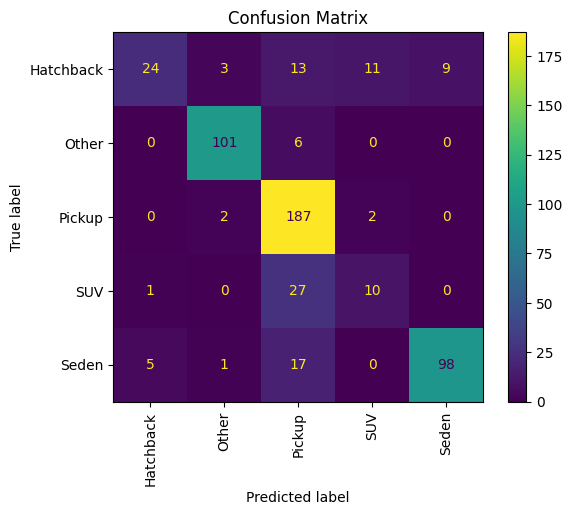

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.2912 - loss: 2.7291 - precision: 0.3148 - recall: 0.0669 - val_accuracy: 0.3752 - val_loss: 1.4868 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.4163 - loss: 1.4185 - precision: 0.5037 - recall: 0.0865 - val_accuracy: 0.4758 - val_loss: 1.2367 - val_precision: 0.7000 - val_recall: 0.2979
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5525 - loss: 1.2021 - precision: 0.6782 - recall: 0.3174 - val_accuracy: 0.5590 - val_loss: 1.1440 - val_precision: 0.7442 - val_recall: 0.3714
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6068 - loss: 1.0851 - precision: 0.7253 - recall: 0.4228 - val_accuracy: 0.7002 - val_loss: 0.8280 - val_precision: 0.8316 - val_recall: 0.6306
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.6382 - loss: 1.0114 - precision: 0.7506 - recall: 0.4911 - val_accuracy: 0.67

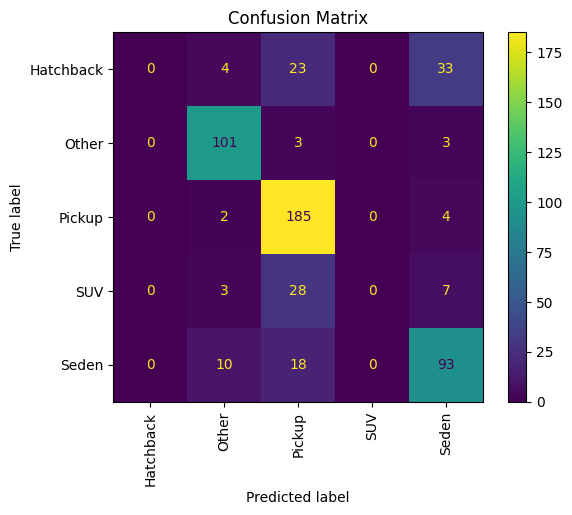

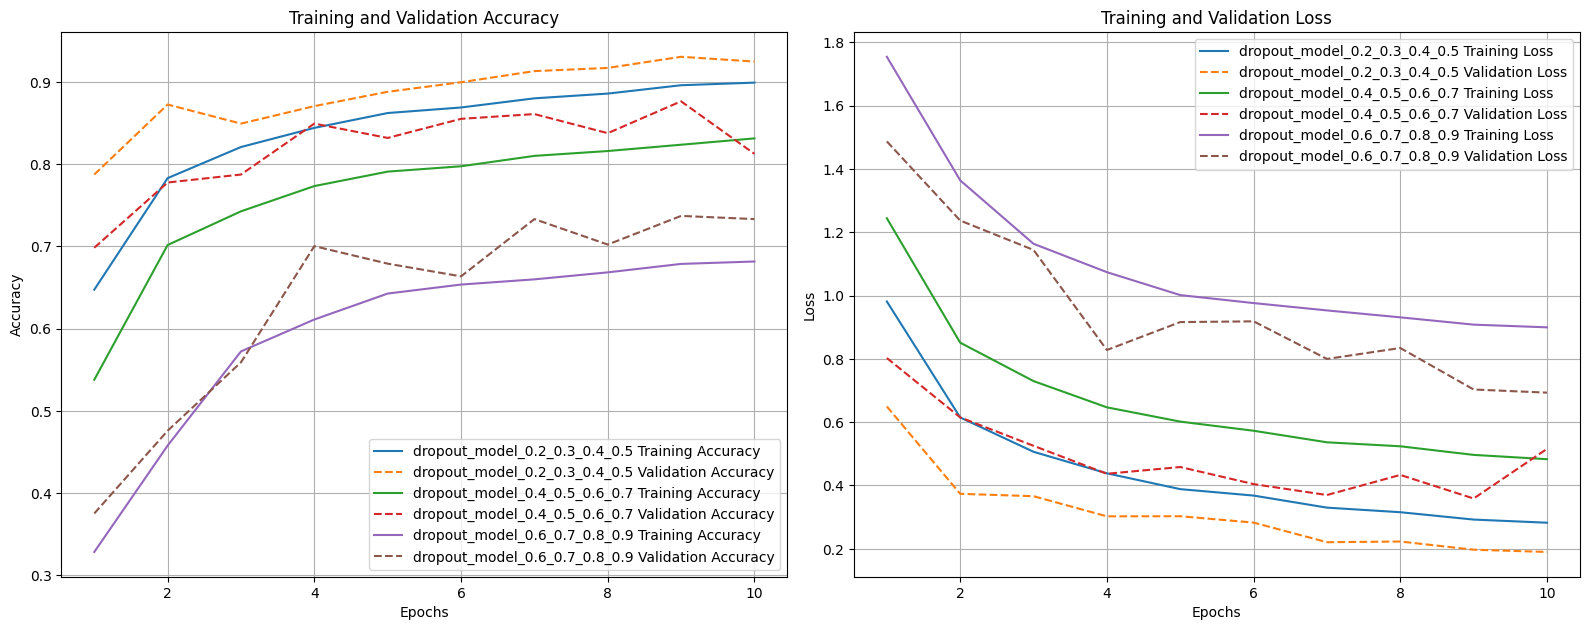

In [ ]:
dropout_rates = [
    [0.2, 0.3, 0.4, 0.5],
    [0.4, 0.5, 0.6, 0.7],
    [0.6, 0.7, 0.8, 0.9]
]

dropout_models = []
dropout_histories = {}

for dropout_rate in dropout_rates:
    dropout_model = get_dropout_model(dropout_rate)
    dropout_models.append(dropout_model)
    dropout_history = dropout_model.fit(
        train_aug_dataset,
        epochs=10,
        validation_data=val_aug_dataset
    )
    dropout_histories[dropout_model.name] = dropout_history
    evaluate_model(dropout_model, val_aug_dataset, class_names)

plot_training_history(dropout_histories, val=True)

## Experiment 10 - Learning Rate

In [ ]:
def get_learning_rate_model(learning_rate):
    name = f"learning_rate_model_{learning_rate}"
    model = Sequential(name=name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.4682 - loss: 1.3172 - precision: 0.5997 - recall: 0.1647 - val_accuracy: 0.6499 - val_loss: 0.9462 - val_precision: 0.7950 - val_recall: 0.4874
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7152 - loss: 0.8095 - precision: 0.8098 - recall: 0.6100 - val_accuracy: 0.7718 - val_loss: 0.6450 - val_precision: 0.8480 - val_recall: 0.6692
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7637 - loss: 0.6725 - precision: 0.8342 - recall: 0.6838 - val_accuracy: 0.7930 - val_loss: 0.5550 - val_precision: 0.8756 - val_recall: 0.7215
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7906 - loss: 0.5945 - precision: 0.8525 - recall: 0.7217 - val_accuracy: 0.8124 - val_loss: 0.4921 - val_precision: 0.8711 - val_recall: 0.7582
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8119 - loss: 0.5329 - precision: 0.8652 - recall: 0.7524 - val_accuracy: 0

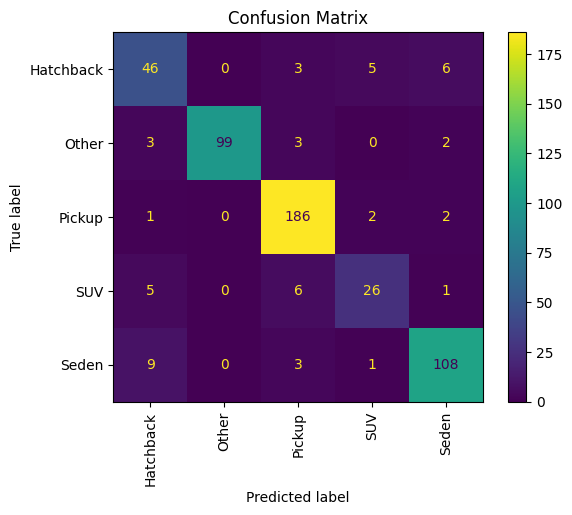

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6255 - loss: 0.9923 - precision: 0.7572 - recall: 0.4571 - val_accuracy: 0.8104 - val_loss: 0.4647 - val_precision: 0.8733 - val_recall: 0.7602
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8016 - loss: 0.5480 - precision: 0.8566 - recall: 0.7485 - val_accuracy: 0.8356 - val_loss: 0.4152 - val_precision: 0.8699 - val_recall: 0.7892
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8383 - loss: 0.4500 - precision: 0.8858 - recall: 0.8007 - val_accuracy: 0.8897 - val_loss: 0.2702 - val_precision: 0.9042 - val_recall: 0.8762
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8601 - loss: 0.3962 - precision: 0.8918 - recall: 0.8292 - val_accuracy: 0.9072 - val_loss: 0.2171 - val_precision: 0.9274 - val_recall: 0.8897
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8723 - loss: 0.3523 - precision: 0.9016 - recall: 0.8467 - val_accuracy: 0.9284 - val

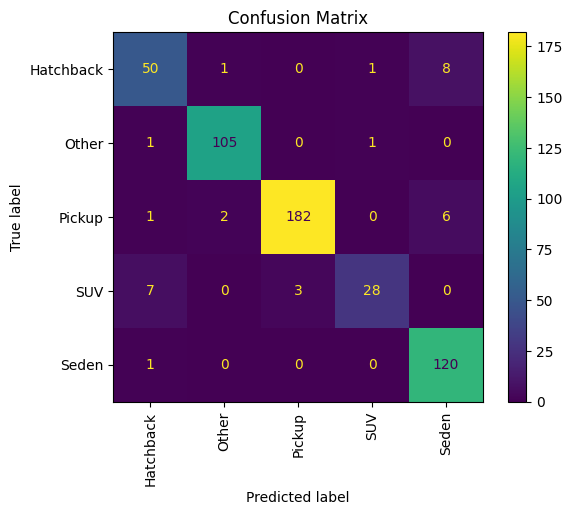

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5336 - loss: 1.2401 - precision: 0.6768 - recall: 0.3184 - val_accuracy: 0.3694 - val_loss: 1.5053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.3687 - loss: 1.5248 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4760 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3690 - loss: 1.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3686 - loss: 1.9923 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.3689 - loss: 1.473

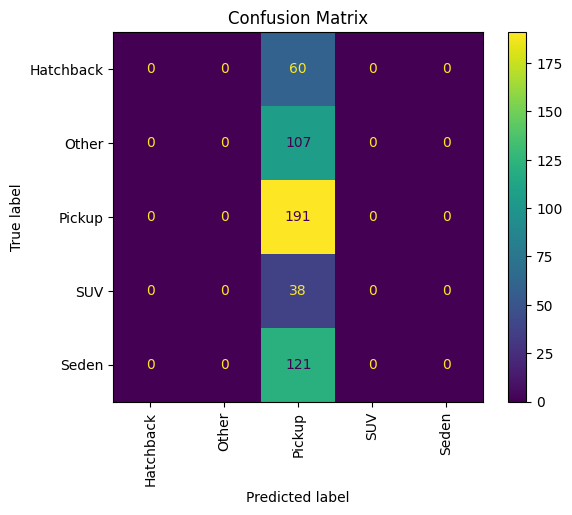

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.3478 - loss: 3.3174 - precision: 0.1931 - recall: 0.0181 - val_accuracy: 0.3694 - val_loss: 1.4760 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3688 - loss: 1.4749 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3691 - loss: 1.4752 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3691 - loss: 1.4749 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3694 - val_loss: 1.4759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3690 - loss: 1.4749 - precisi

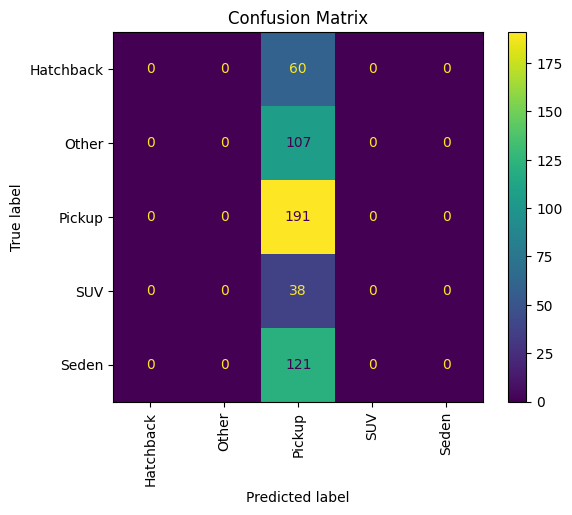

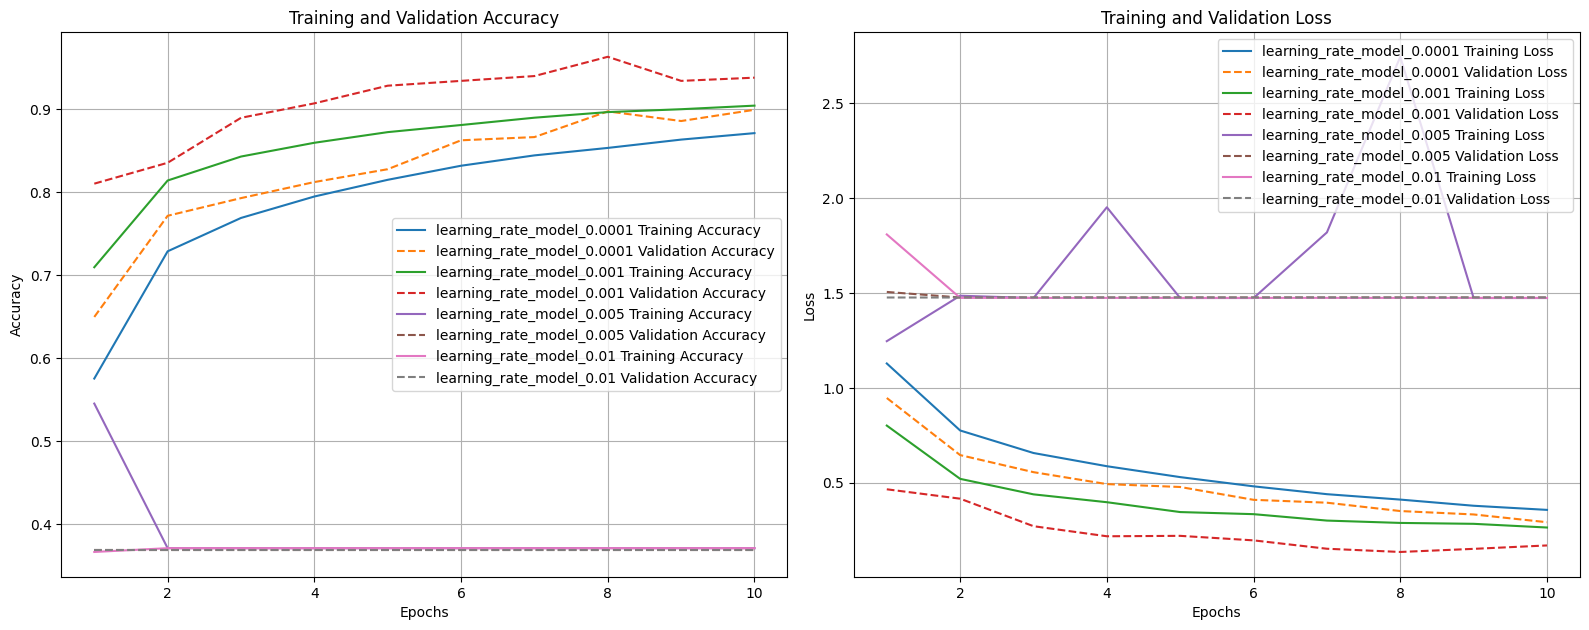

In [ ]:
learning_rates = [0.0001, 0.001, 0.005, 0.01]

learning_rate_models = []
learning_rate_histories = {}

for learning_rate in learning_rates:
    learning_rate_model = get_learning_rate_model(learning_rate)
    learning_rate_models.append(learning_rate_model)
    learning_rate_history = learning_rate_model.fit(
        train_aug_dataset,
        epochs=10,
        validation_data=val_aug_dataset
    )
    learning_rate_histories[learning_rate_model.name] = learning_rate_history
    evaluate_model(learning_rate_model, val_aug_dataset, class_names)

plot_training_history(learning_rate_histories, val=True)

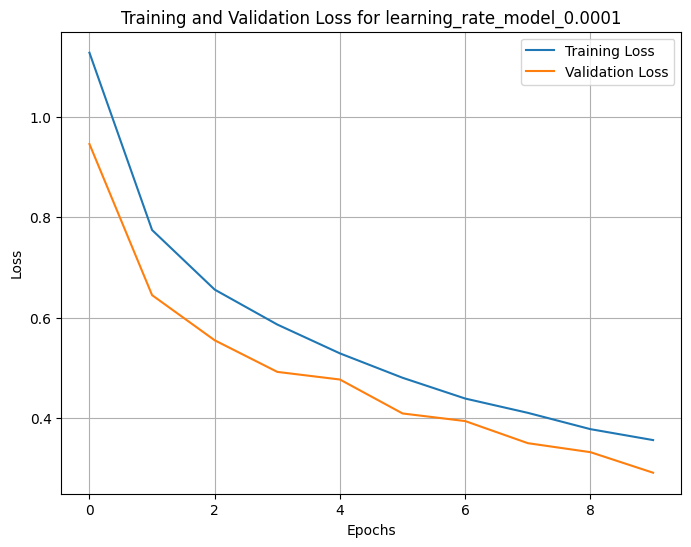

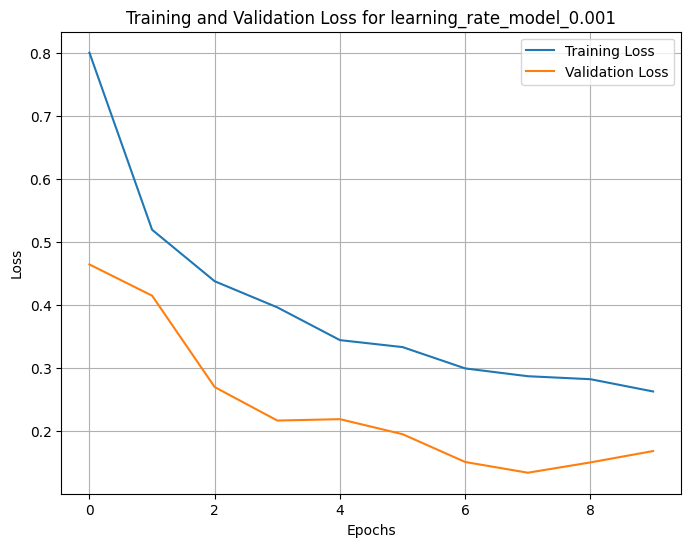

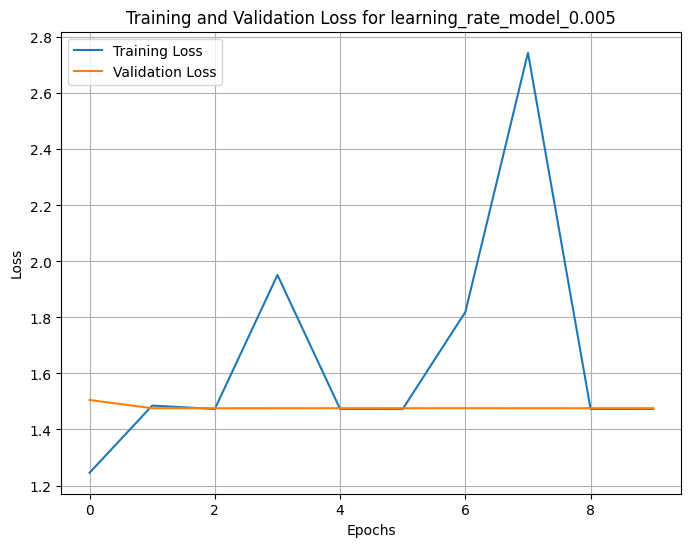

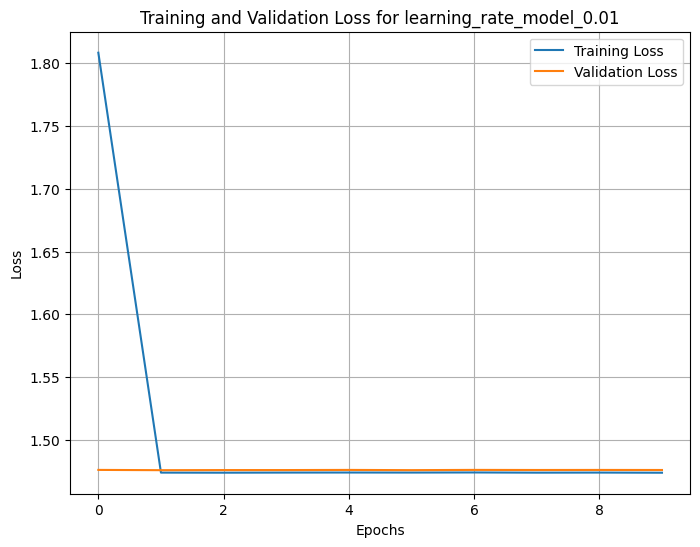

In [ ]:
def plot_individual_learning_rates(learning_rate_histories):
    for model_name, history in learning_rate_histories.items():
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to plot the losses
plot_individual_learning_rates(learning_rate_histories)

## Experiment 11 - Global Average Pooling

In [ ]:
def get_gap_model(name="gap_model"):
    model = Sequential(name=name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.4831 - loss: 1.2770 - precision: 0.6390 - recall: 0.2247 - val_accuracy: 0.7157 - val_loss: 0.7747 - val_precision: 0.8130 - val_recall: 0.6054
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7440 - loss: 0.6973 - precision: 0.8261 - recall: 0.6673 - val_accuracy: 0.7988 - val_loss: 0.5655 - val_precision: 0.8600 - val_recall: 0.7485
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8057 - loss: 0.5449 - precision: 0.8607 - recall: 0.7481 - val_accuracy: 0.7853 - val_loss: 0.5799 - val_precision: 0.8323 - val_recall: 0.7485
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8261 - loss: 0.4851 - precision: 0.8675 - recall: 0.7836 - val_accuracy: 0.8337 - val_loss: 0.5162 - val_precision: 0.8731 - val_recall: 0.7718
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8560 - loss: 0.4148 - precision: 0.8861 - recall: 0.8219 - val_accuracy: 0.8356 - val

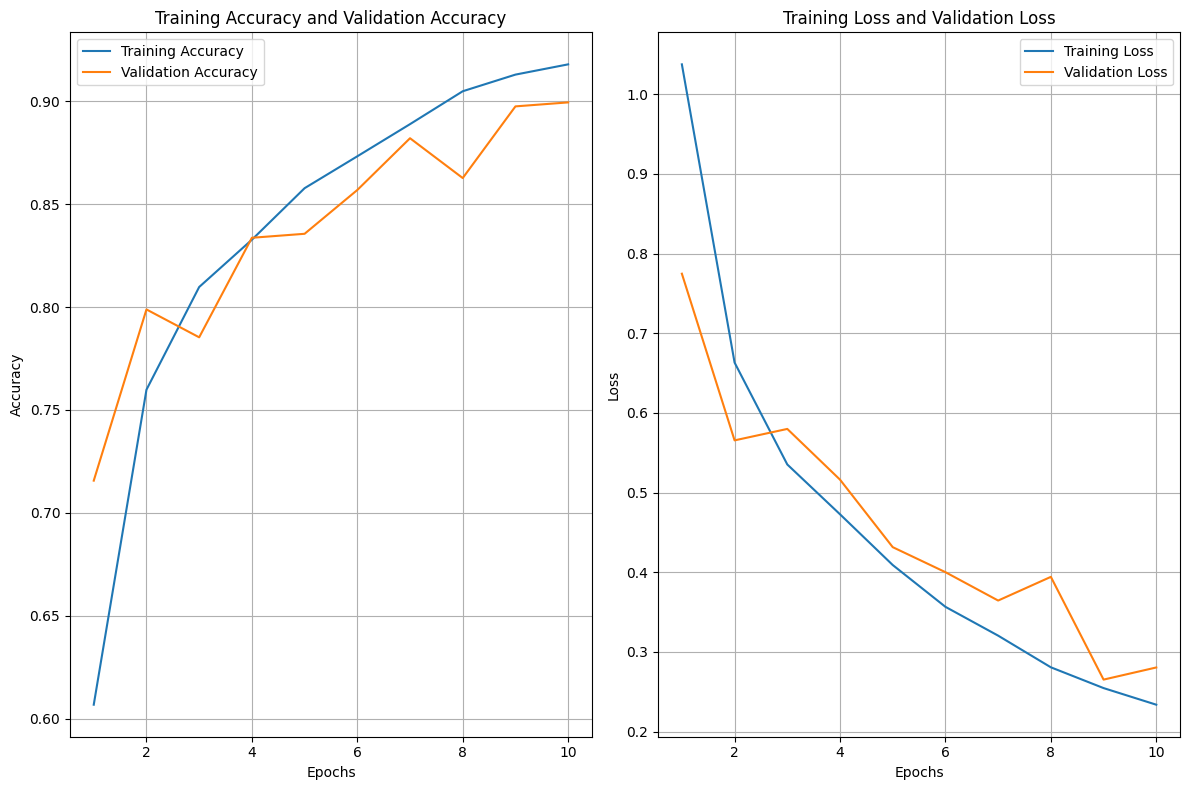

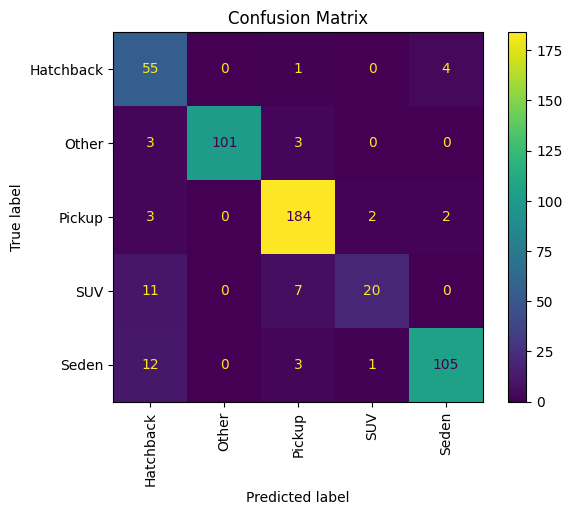

array([[ 55,   0,   1,   0,   4],
       [  3, 101,   3,   0,   0],
       [  3,   0, 184,   2,   2],
       [ 11,   0,   7,  20,   0],
       [ 12,   0,   3,   1, 105]])

In [ ]:
gap_model = get_gap_model()
gap_model_history = gap_model.fit(
    train_aug_dataset,
    epochs=10,
    validation_data=val_aug_dataset
)

plot_training_history(gap_model_history, val=True)
evaluate_model(gap_model, val_aug_dataset, class_names)

## Experiment 12 - Even Deeper

In [ ]:
def get_deeper_model(num_blocks):
    name = f"deeper_model_{num_blocks}_blocks"
    model = Sequential(name=name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # 4th Conv Block
    if num_blocks >= 4:
        model.add(Conv2D(filters=128, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
        model.add(Conv2D(filters=128, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

    # 5th Conv block
    if num_blocks >= 5:
        model.add(Conv2D(filters=256, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
        model.add(Conv2D(filters=256, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

    # Global Average Pooling
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    model.summary()

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "deeper_model_3_blocks"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,613 (1.28 MB)

 Trainable params: 334,613 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.6247 - loss: 0.9952 - precision: 0.7428 - recall: 0.4607 - val_accuracy: 0.8221 - val_loss: 0.5012 - val_precision: 0.8750 - val_recall: 0.7447
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8013 - loss: 0.5592 - precision: 0.8606 - recall: 0.7351 - val_accuracy: 0.8723 - val_loss: 0.3944 - val_precision: 0.8991 - val_recall: 0.8104
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8325 - loss: 0.4610 - precision: 0.8730 - recall: 0.7879 - val_accuracy: 0.8685 - val_loss: 0.3318 - val_precision: 0.8939 - val_recall: 0.8472
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8516 - loss: 0.4142 - precision: 0.8890 - recall: 0.8128 - val_accuracy: 0.8588 - val_loss: 0.3752 - val_precision: 0.8826 - val_recall: 0.8433
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8579 - loss: 0.3973 - precision: 0.8920 - recall: 0.8219 - val_accuracy: 0

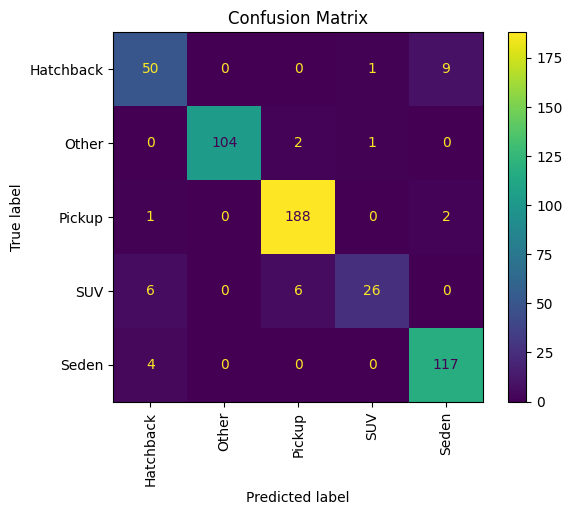

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "deeper_model_4_blocks"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,981 (1.62 MB)

 Trainable params: 424,981 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5440 - loss: 1.1633 - precision: 0.6862 - recall: 0.3277 - val_accuracy: 0.7930 - val_loss: 0.5759 - val_precision: 0.8591 - val_recall: 0.7311
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7557 - loss: 0.7057 - precision: 0.8218 - recall: 0.6819 - val_accuracy: 0.8298 - val_loss: 0.4824 - val_precision: 0.8831 - val_recall: 0.7892
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7938 - loss: 0.5792 - precision: 0.8519 - recall: 0.7370 - val_accuracy: 0.8549 - val_loss: 0.3499 - val_precision: 0.8804 - val_recall: 0.8259
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8065 - loss: 0.5375 - precision: 0.8631 - recall: 0.7601 - val_accuracy: 0.8607 - val_loss: 0.3756 - val_precision: 0.9203 - val_recall: 0.8259
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8198 - loss: 0.5084 - precision: 0.8660 - recall: 0.7715 - val_accuracy: 0

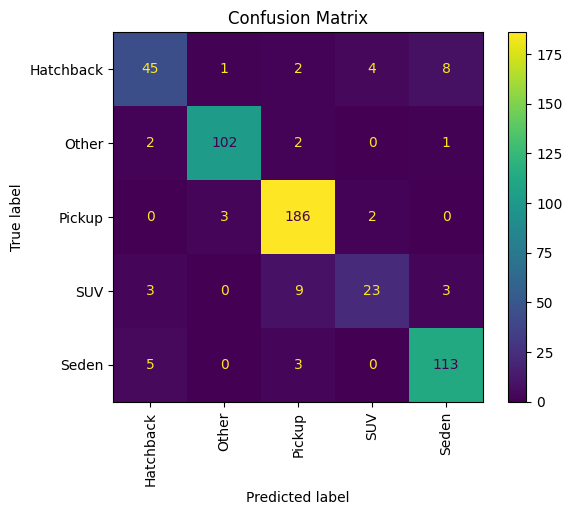

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "deeper_model_5_blocks"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 4, 4, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,244,693 (4.75 MB)

 Trainable params: 1,244,693 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.4874 - loss: 1.3035 - precision: 0.6244 - recall: 0.2295 - val_accuracy: 0.7485 - val_loss: 0.7194 - val_precision: 0.8678 - val_recall: 0.6093
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7197 - loss: 0.7823 - precision: 0.8105 - recall: 0.6275 - val_accuracy: 0.7485 - val_loss: 0.6757 - val_precision: 0.8333 - val_recall: 0.6673
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7407 - loss: 0.7310 - precision: 0.8283 - recall: 0.6522 - val_accuracy: 0.7950 - val_loss: 0.6035 - val_precision: 0.8300 - val_recall: 0.7273
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7624 - loss: 0.6652 - precision: 0.8413 - recall: 0.6846 - val_accuracy: 0.7911 - val_loss: 0.5086 - val_precision: 0.8581 - val_recall: 0.7602
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7760 - loss: 0.6351 - precision: 0.8519 - recall: 0.7012 - val_accuracy: 0

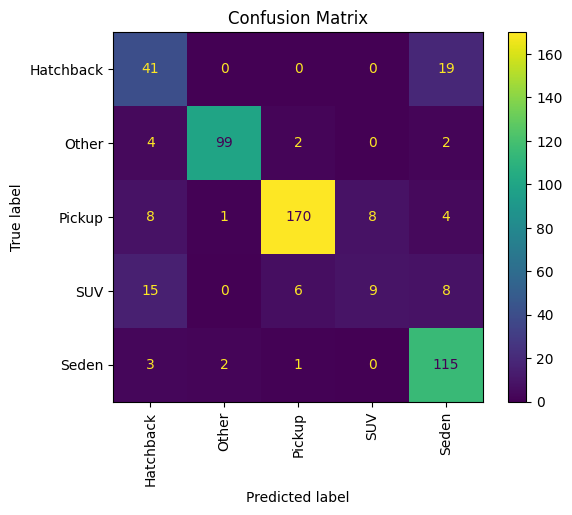

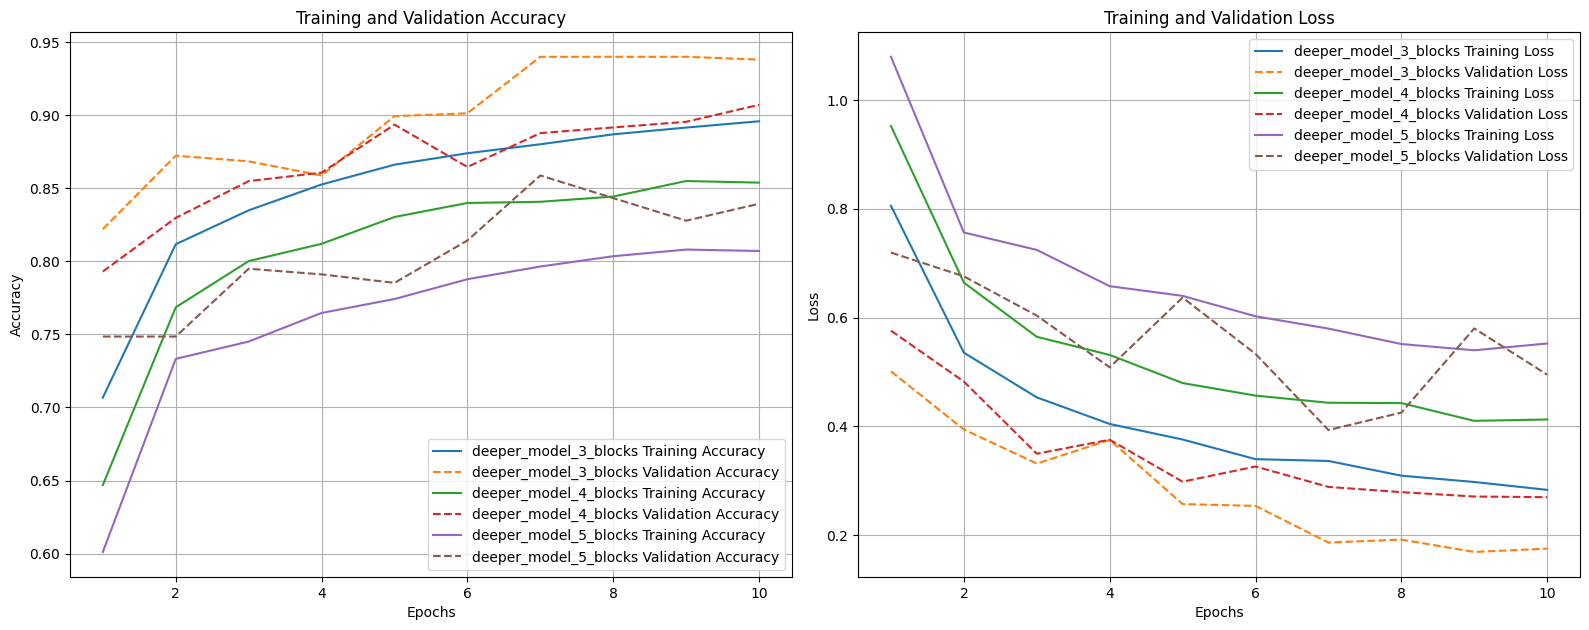

In [ ]:
model_blocks = [3,4,5]
deeper_models = []
deeper_model_histories = {}

for num_blocks in model_blocks:
    deeper_model = get_deeper_model(num_blocks)
    deeper_models.append(deeper_model)
    deeper_model_history = deeper_model.fit(
    train_aug_dataset,
    epochs=10,
    validation_data=val_aug_dataset
    )
    deeper_model_histories[deeper_model.name] = deeper_model_history
    evaluate_model(deeper_model, val_aug_dataset, class_names)

plot_training_history(deeper_model_histories, val=True)

# Final Model

In [ ]:
def get_final_model(name="final_model"):
    model = Sequential(name=name)
    initializer = HeNormal()

    # 1st Conv Block
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer, input_shape=[64, 64, 3]))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # 2nd Conv Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # 3rd Conv Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='swish', padding='same', kernel_initializer=initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 64, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,613 (1.28 MB)

 Trainable params: 334,613 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


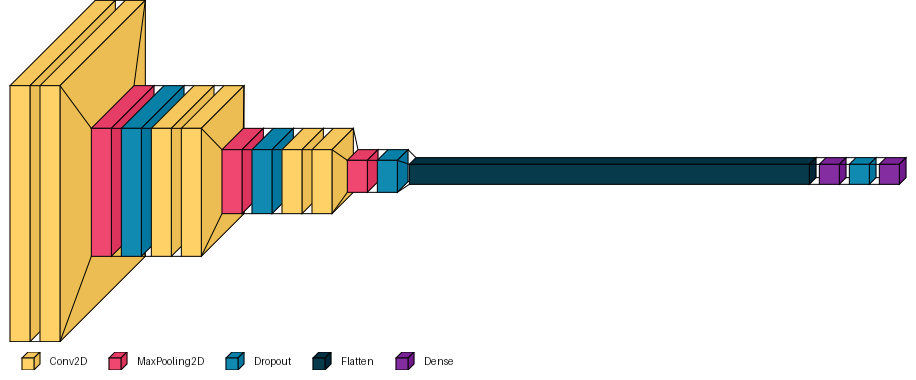

In [ ]:
final_model = get_final_model()
final_model.summary()
visualkeras.layered_view(final_model, legend=True)

In [ ]:
final_model_history = final_model.fit(
    train_aug_dataset,
    epochs=10,
    validation_data=val_aug_dataset
)

plot_training_history(final_model_history, val=True)
conf_matrix = evaluate_model(final_model, val_aug_dataset, class_names)

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6028 - loss: 1.0558 - precision: 0.7398 - recall: 0.4186 - val_accuracy: 0.8201 - val_loss: 0.4564 - val_precision: 0.8991 - val_recall: 0.7582
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8005 - loss: 0.5622 - precision: 0.8562 - recall: 0.7410 - val_accuracy: 0.8569 - val_loss: 0.3435 - val_precision: 0.8917 - val_recall: 0.8124
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8333 - loss: 0.4567 - precision: 0.8795 - recall: 0.7916 - val_accuracy: 0.8975 - val_loss: 0.2673 - val_precision: 0.9340 - val_recall: 0.8762
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8587 - loss: 0.3954 - precision: 0.8955 - recall: 0.8228 - val_accuracy: 0.9110 - val_loss: 0.2515 - val_precision: 0.9296 - val_recall: 0.8936
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8668 - loss: 0.3748 - precision: 0.8979 - recall: 0.8376 - val_accuracy: 0

NameError: name 'model_history_dictionary' is not defined

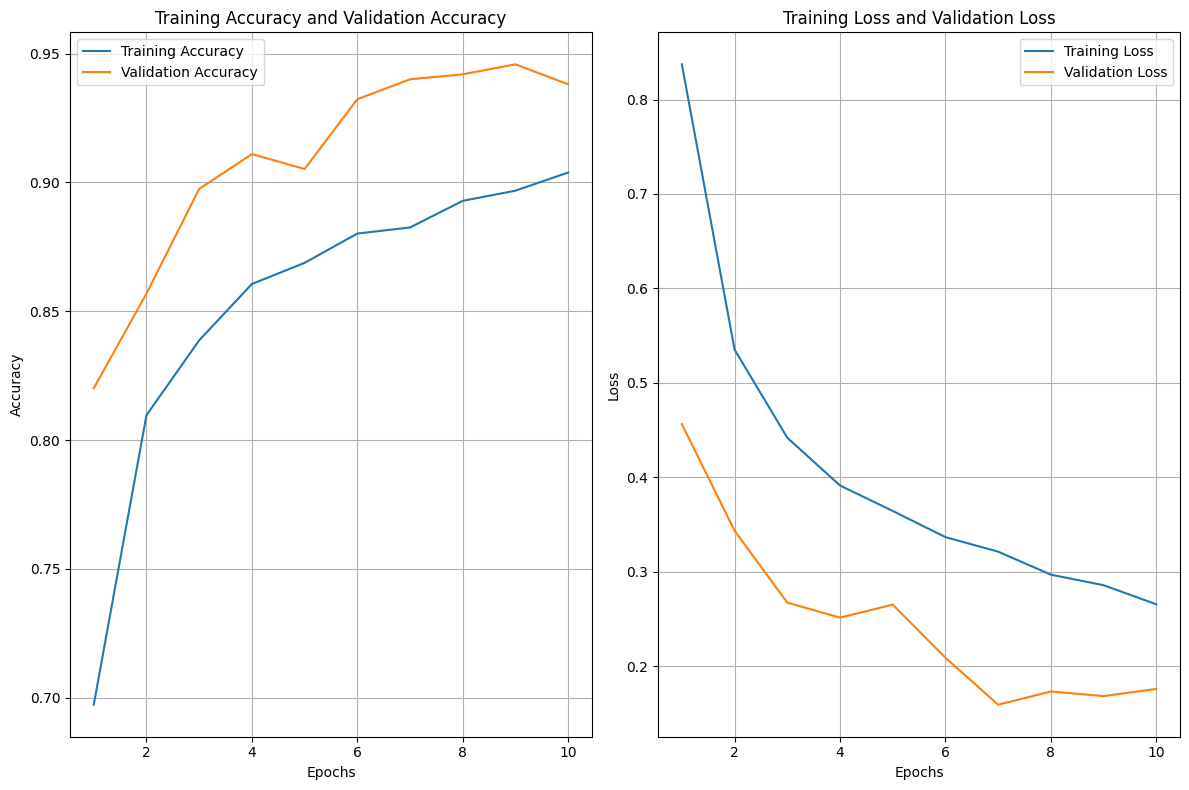

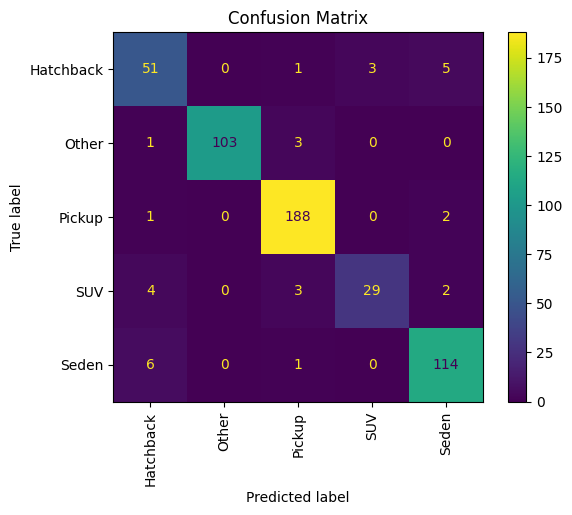

In [ ]:
plot_training_history(final_model_history, val=True)
conf_matrix = evaluate_model(final_model, val_aug_dataset, class_names)

# Explainable AI

## Test Prediction

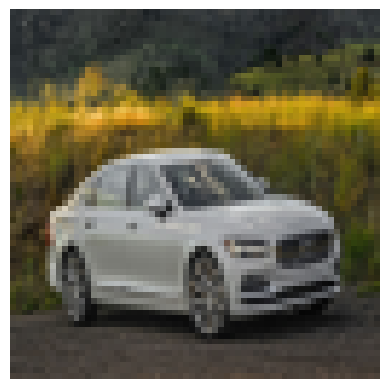

Image shape: (1, 64, 64, 3)
Pixel value range: 0.01568627450980392 to 0.9647058823529412


In [ ]:
# Load and resize the image
test_path = '/content/drive/My Drive/Deep_learning_unit/AssignmentFinal/sedan.jpg'
true_label = "Seden"
image = PIL.Image.open(test_path)

image_size = (64, 64)
image = image.resize(image_size)

# Convert to array
image_array = np.array(image)

# Normalize pixel values to [0, 1]
image_array = image_array / 255.0

# Expand dimensions to add batch size (for model input)
image_array = np.expand_dims(image_array, axis=0)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print shape and range to verify
print(f"Image shape: {image_array.shape}")
print(f"Pixel value range: {image_array.min()} to {image_array.max()}")


In [ ]:
model_prediction = final_model.predict(image_array)
predicted_class = np.argmax(model_prediction, axis=-1)[0]
predicted_class_name = class_names[predicted_class]

print(f"Model Prediction: {model_prediction}")
print(f"The predicted class is: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model Prediction: [[1.4170723e-01 6.4986591e-07 8.5829210e-01 3.2080800e-11 3.4979404e-08]]
The predicted class is: Pickup


## LIME

In [ ]:
def get_random_samples_per_class(dataset, n):
    """
    Get n random samples per class from a tf.data.Dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to sample from. Assumes batched data.
        n (int): Number of samples per class.

    Returns:
        dict: A dictionary where keys are class indices and values are lists of (image, label) tuples.
    """
    # Convert the dataset to a list of batches
    dataset_list = list(dataset.as_numpy_iterator())

    # Flatten the batches into a single list of images and labels
    all_images = np.concatenate([batch[0] for batch in dataset_list], axis=0)
    all_labels = np.concatenate([batch[1] for batch in dataset_list], axis=0)

    # Get class indices (assumes one-hot encoded labels)
    class_indices = np.argmax(all_labels, axis=1)

    # Group images and labels by class
    grouped_by_class = {}
    for idx, (image, label) in enumerate(zip(all_images, all_labels)):
        class_idx = class_indices[idx]
        if class_idx not in grouped_by_class:
            grouped_by_class[class_idx] = []
        grouped_by_class[class_idx].append((image, label))

    # Randomly sample n items per class
    sampled_per_class = {}
    for class_idx, items in grouped_by_class.items():
        sampled_per_class[class_idx] = random.sample(items, min(n, len(items)))

    return sampled_per_class

In [ ]:
def generate_prediction_sample(exp, exp_class, weight, num_features, show_positive = True, hide_background = False):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=num_features,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    image_with_boundaries = mark_boundaries(image, mask)
    return image_with_boundaries

def generate_exp_figures(sampled_data, class_names):
    """
    Plot images from sampled data with their class labels and return the plot as a Figure object.

    Args:
        sampled_data (dict): Output of get_random_samples_per_class. A dictionary where
                             keys are class indices and values are lists of (image, label) tuples.
        class_names (list): List of class names corresponding to class indices.

    Returns:
        figures (list): A list of matplotlib Figure objects, one for each class.
    """
    figures = []
    for class_idx, samples in sampled_data.items():
        # Create a new figure
        fig = plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_names[class_idx]}", fontsize=16)

        for i, (image, label) in enumerate(samples):
            ax = fig.add_subplot(1, len(samples), i + 1)

            # Rescale image if necessary
            if image.max() <= 1.0:  # Check if the image is in [0, 1]
                image = (image * 255).astype("uint8")

            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Class: {class_names[class_idx]}")

        # Add the figure to the list of figures
        figures.append(fig)

    # Return the list of Figure objects
    return figures

def gen_image_exp(image, model, explainer):
    image_exp = explainer.explain_instance(
        image,                 # The image for which you want to explain the prediction
        model.predict,                 # The model's prediction function
        top_labels=5,                  # Number of top predicted labels to consider
        hide_color=0,                  # Don't hide any colors in the explanation
        num_samples=1000               # Number of random perturbations to use for explanation
    )
    return image_exp

def explain_val(val_dataset, model, class_names, n_samples_per_class=5):
    """
    Generate a single plot with explanations for all classes in the validation dataset.

    Args:
        val_dataset (tf.data.Dataset): The validation dataset containing images and labels.
        model: The model used for predictions.
        class_names (list): List of class names corresponding to class indices.
        n_samples_per_class (int): Number of samples to generate explanations for per class.

    Returns:
        None
    """
    # Initialize the LimeImageExplainer
    explainer = lime_image.LimeImageExplainer()

    # Get sampled data for explanation
    sampled_data = get_random_samples_per_class(val_dataset, n_samples_per_class)

    # Create a single figure with a grid layout (rows = classes, columns = samples per class)
    fig, axes = plt.subplots(len(sampled_data), n_samples_per_class, figsize=(n_samples_per_class * 4, len(sampled_data) * 4))
    fig.suptitle("Model Explanations for Each Class", fontsize=20)

    for row_idx, (class_idx, samples) in enumerate(sampled_data.items()):
        for col_idx, (image, label) in enumerate(samples):
            # Generate explainability for the current image
            image_exp = gen_image_exp(image, model, explainer)

            # Get the explanation overlay
            image_with_exp = generate_prediction_sample(
                image_exp,
                exp_class=image_exp.top_labels[0],  # Top predicted label
                weight=0.1,
                num_features=15,
                show_positive=False,
                hide_background=False
            )

            # Rescale the original image if necessary
            if image[0].max() <= 1.0:
                image[0] = (image[0] * 255).astype("uint8")

            # Plot the image with explanation
            ax = axes[row_idx, col_idx] if len(sampled_data) > 1 else axes[col_idx]
            ax.imshow(image_with_exp)
            ax.axis('off')

            # Add class label as the title for the first image in each row
            if col_idx == 0:
                ax.set_ylabel(class_names[class_idx], fontsize=14, rotation=90, labelpad=10)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

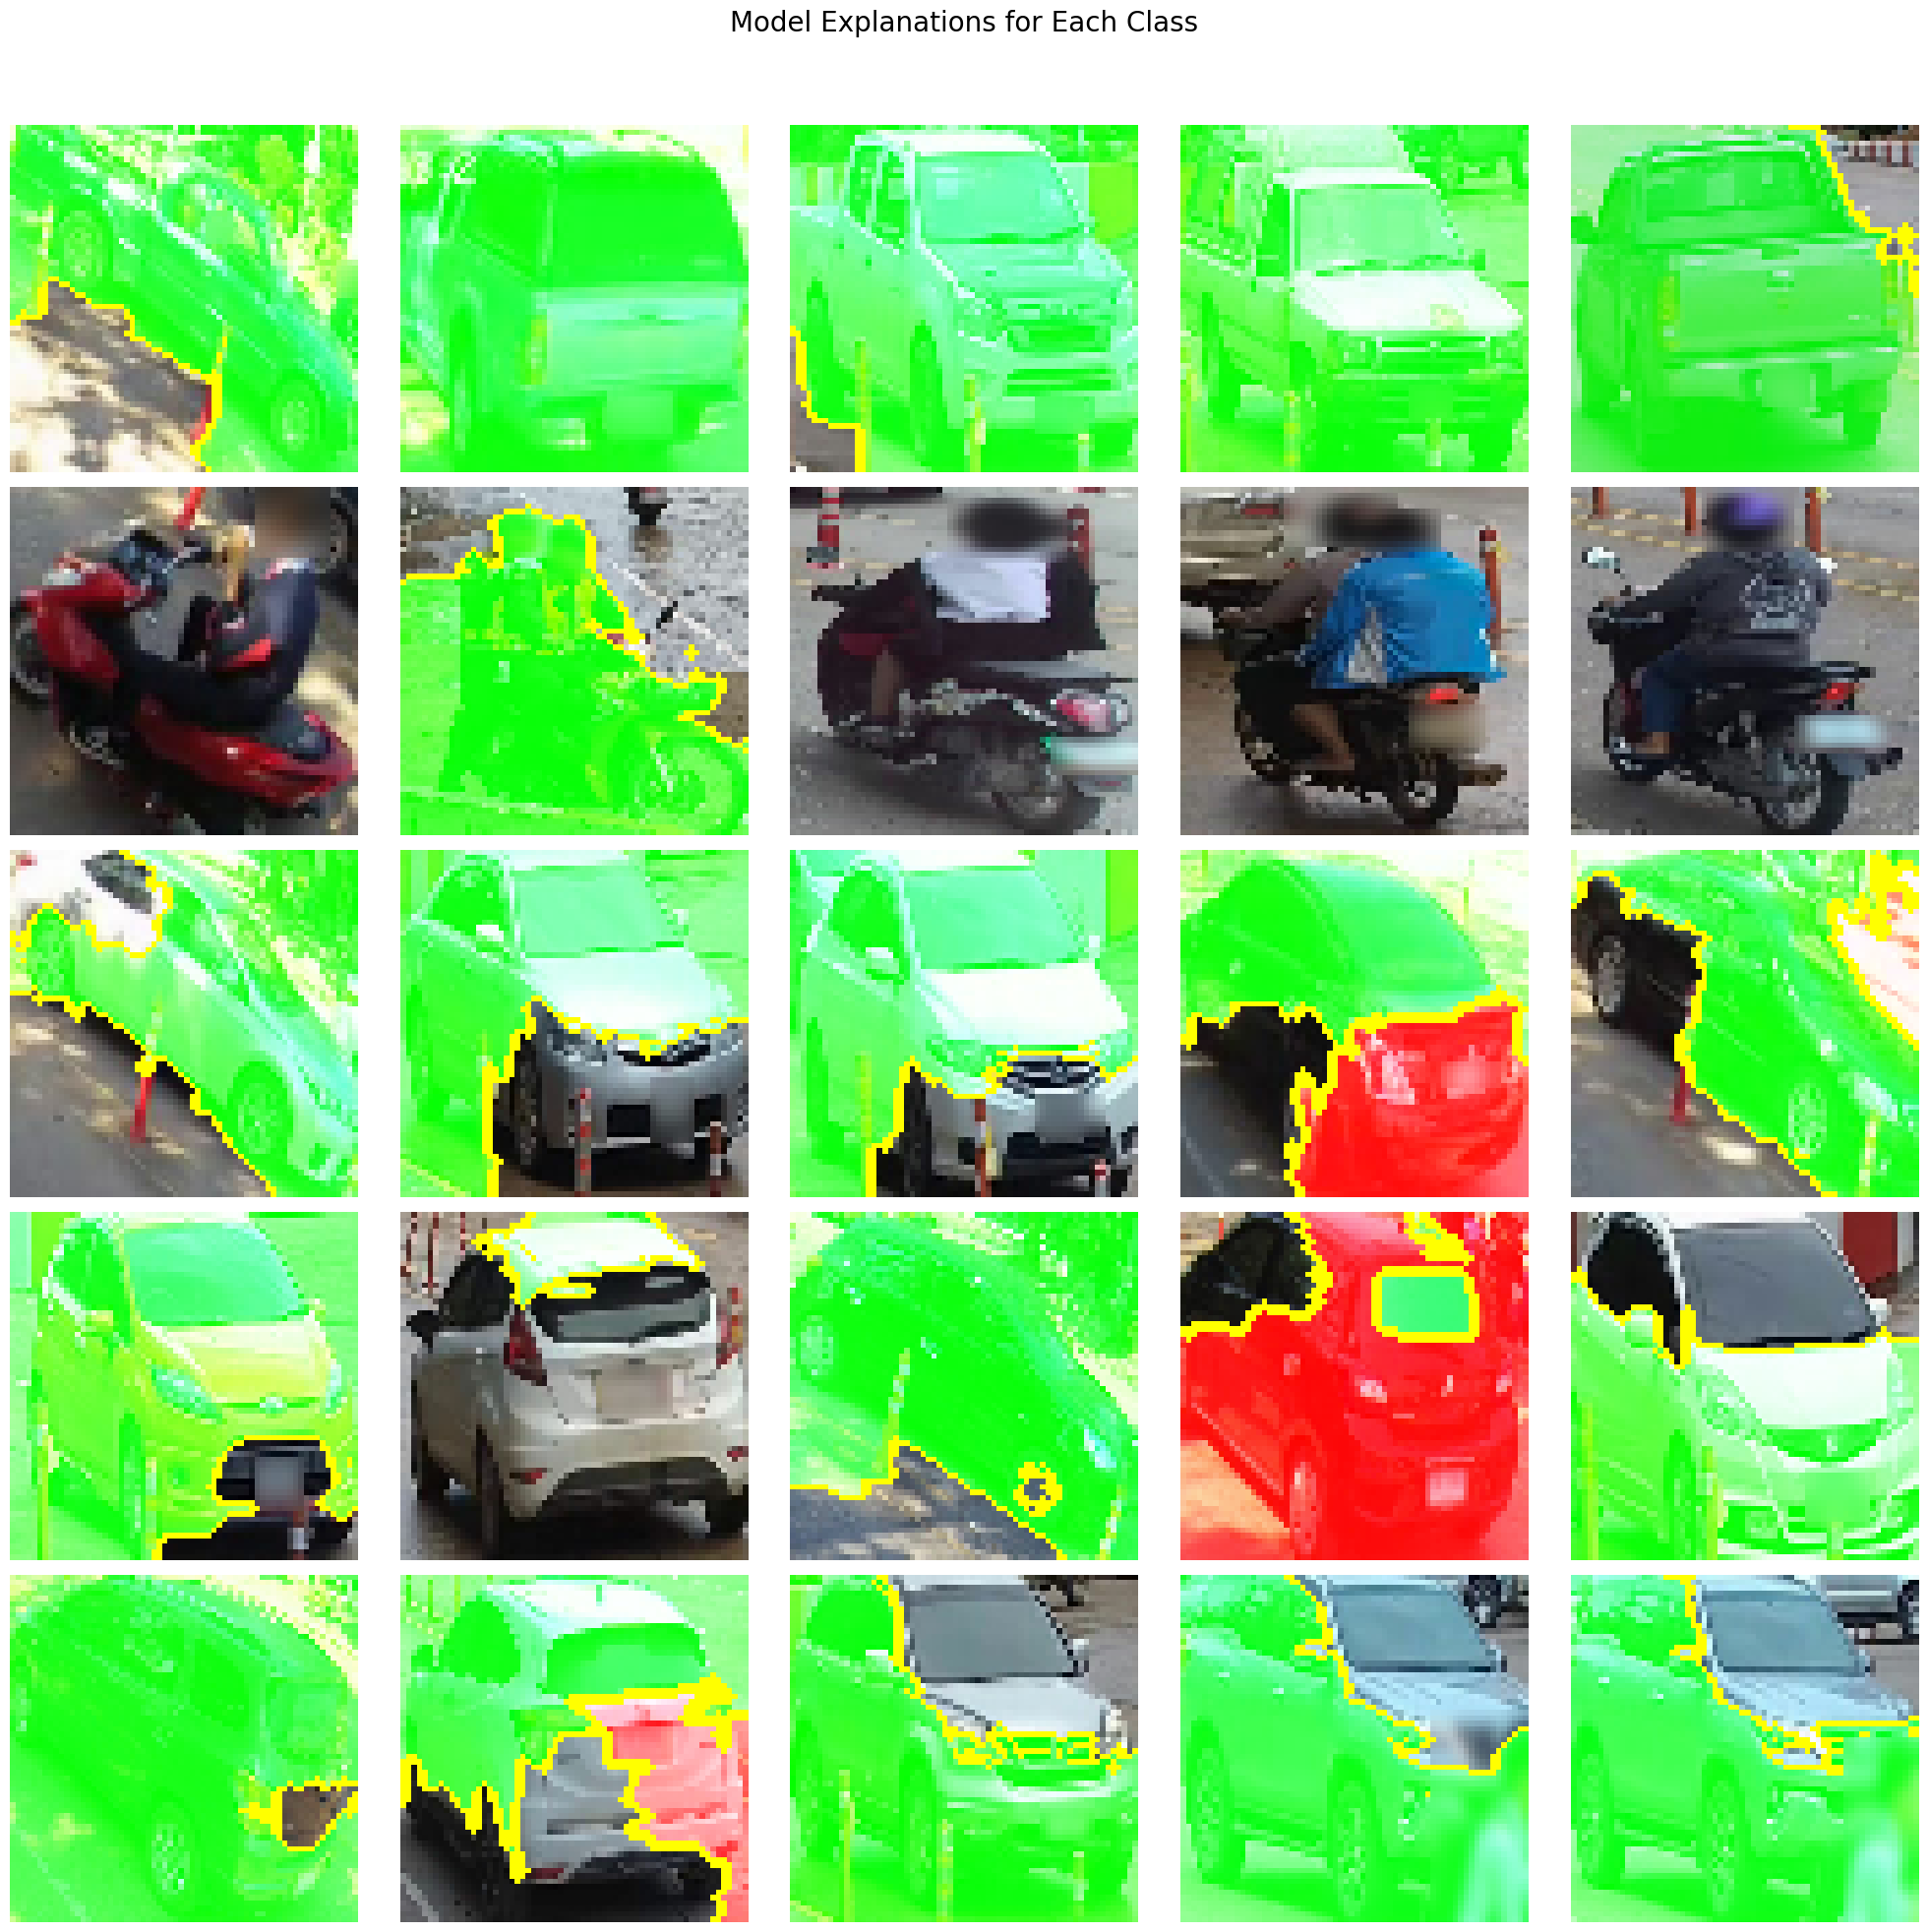

In [ ]:
explain_val(val_aug_dataset, final_model, class_names, n_samples_per_class=5)